# Carga de datos

In [18]:
import pandas as pd
import os

archivos = [
    "../data/interim/validated_range_fecha_familia_20250630.parquet",
    "../data/interim/validated_range_semanal_familia_20250630.parquet",
    "../data/interim/validated_range_monthly_familia_20250630.parquet"
]
# Cargar los datos de cada archivo en una lista de DataFrames
dfs = []
for archivo in archivos:
    if os.path.exists(archivo):
        dfs.append(pd.read_parquet(archivo))
    else:
        print(f"Archivo no encontrado: {archivo}")

# Mensajes de confirmación de que se cargaron los archivos
for i, df in enumerate(dfs):
    print(f"Archivo {i+1} cargado con éxito: {archivos[i]} - Número de filas: {len(df)}")

Archivo 1 cargado con éxito: ../data/interim/validated_range_fecha_familia_20250630.parquet - Número de filas: 9989
Archivo 2 cargado con éxito: ../data/interim/validated_range_semanal_familia_20250630.parquet - Número de filas: 1678
Archivo 3 cargado con éxito: ../data/interim/validated_range_monthly_familia_20250630.parquet - Número de filas: 390


# Análisis global de las ventas
Entender el comportamiento de las ventas por día, semana y mes

## Evolución mensual por año

df_diario cargado con éxito: ../data/interim/validated_range_fecha_familia_20250630.parquet - Número de filas: 9989
df_semanal cargado con éxito: ../data/interim/validated_range_semanal_familia_20250630.parquet - Número de filas: 1678
df_mensual cargado con éxito: ../data/interim/validated_range_monthly_familia_20250630.parquet - Número de filas: 390


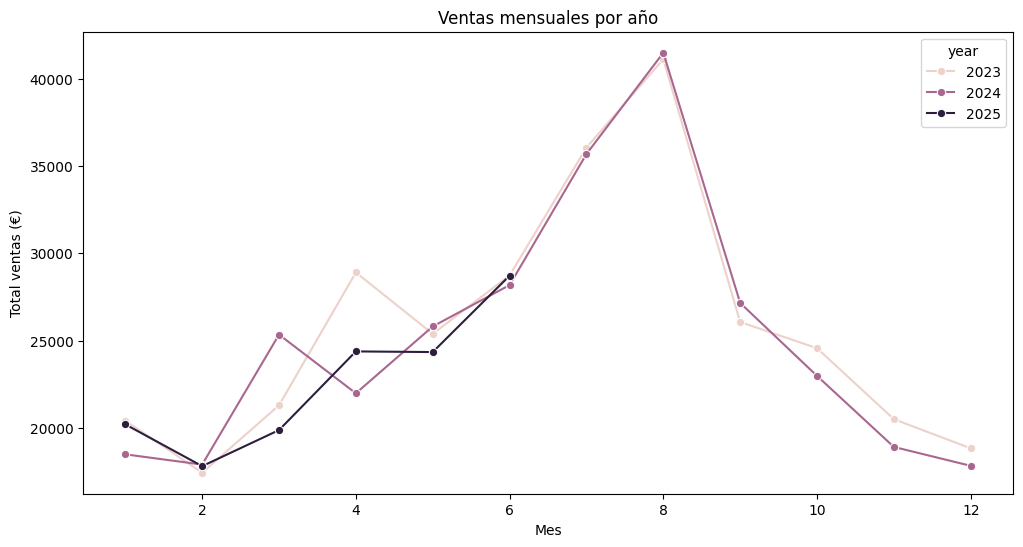

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

nombres = ['df_diario', 'df_semanal', 'df_mensual']
dfs = {}

for archivo, nombre in zip(archivos, nombres):
    if os.path.exists(archivo):
        dfs[nombre] = pd.read_parquet(archivo)
        print(f"{nombre} cargado con éxito: {archivo} - Número de filas: {len(dfs[nombre])}")
    else:
        print(f"Archivo no encontrado: {archivo}")

# --- EDA Paso 2: Análisis por mes, semana, día, y comparativa anual ---
df_fleca_agg = dfs['df_diario']

# 2.1 Ventas mensuales por año
df_mensual_eda = df_fleca_agg.groupby(['year', 'month'])['total'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=df_mensual_eda, x='month', y='total', hue='year', marker='o')
plt.title('Ventas mensuales por año')
plt.xlabel('Mes')
plt.ylabel('Total ventas (€)')
plt.show()


**Comentarios: Evolución mensual por año**

- Tendencia clara: Las ventas siguen un patrón estacional muy marcado, con un pico máximo en agosto todos los años. Este es un comportamiento típico en zonas turísticas.

- 2025 termina en junio, por eso la línea acaba antes. La tendencia de 2025 hasta junio sigue un comportamiento similar a los otros años, sin anomalías visibles.

- Importante: La pendiente de subida entre abril y agosto parece consistente entre años, lo que es relevante para modelar el incremento progresivo hacia el verano.

**Conclusión:** Confirma la estacionalidad anual y que un modelo estacional o con componentes exógenos como verano será esencial.

##  Evolución semanal por año

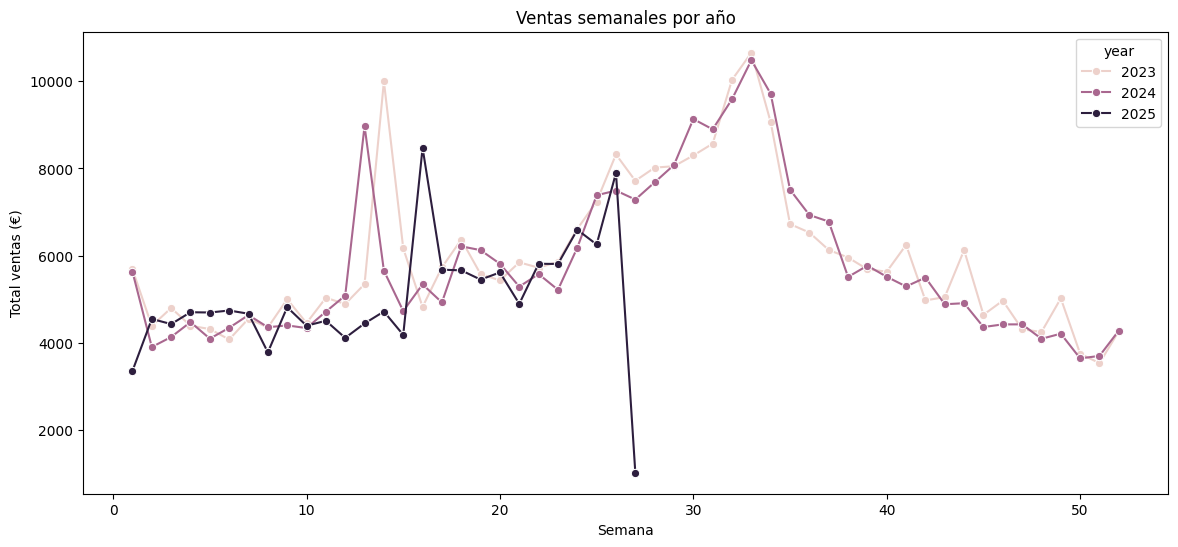

In [3]:
# 2.2 Ventas semanales por año
df_semanal_eda = df_fleca_agg.groupby(['year', 'week'])['total'].sum().reset_index()
plt.figure(figsize=(14,6))
sns.lineplot(data=df_semanal_eda, x='week', y='total', hue='year', marker='o')
plt.title('Ventas semanales por año')
plt.xlabel('Semana')
plt.ylabel('Total ventas (€)')
plt.show()



**Comentarios: Evolución semanal por año**

- El gráfico semanal confirma el mismo patrón observado en la agregación mensual pero revela con más detalle la volatilidad y fluctuación entre semanas.

- En el caso de 2025, la caída abrupta a partir de la semana 25 es simplemente el reflejo de que los datos solo llegan hasta el 30 de junio de 2025, por lo que el resto del año permanece vacío.

- La evolución hasta la semana 25 sigue un comportamiento coherente con años anteriores, con un crecimiento progresivo que anticipa el pico de verano.

**Conclusión:** La granularidad semanal permite detectar fluctuaciones de corto plazo que no se aprecian en la visión mensual. Esto es útil para decidir si un forecasting semanal puede aportar más detalle al negocio frente a un enfoque mensual, especialmente si se quiere capturar la dinámica previa al verano.

## Ventas por día de la semana

Text(0, 0.5, 'Total ventas (€)')

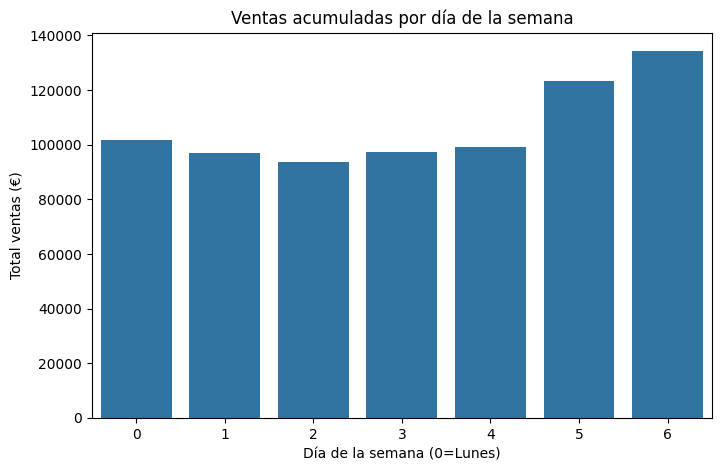

In [4]:
# 2.3 Ventas por día de la semana
df_dow = df_fleca_agg.groupby('day_of_week')['total'].sum().reset_index()
plt.figure(figsize=(8,5))
sns.barplot(data=df_dow, x='day_of_week', y='total')
plt.title('Ventas acumuladas por día de la semana')
plt.xlabel('Día de la semana (0=Lunes)')
plt.ylabel('Total ventas (€)')

**Comentarios: Ventas por día de la semana**

- Sábados y domingos concentran el pico de ventas, siendo el domingo el mejor día claramente.

- Esto tiene sentido en un contexto turístico y de consumo local, con mayor afluencia de personas los fines de semana.

**Conclusión**: El día de la semana es un predictor clave en cualquier modelo que construyas. Asegúrate de incluirlo como variable dummy o codificación cíclica.

## Comparativa año contra año por mes

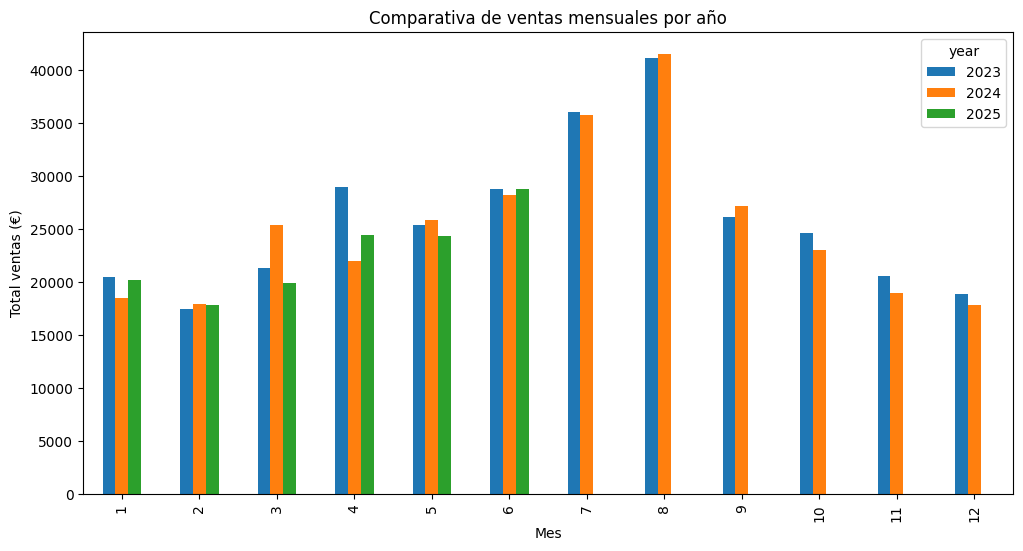

In [5]:
# 2.4 Comparativa año contra año por mes
df_yoy = df_fleca_agg.groupby(['year', 'month'])['total'].sum().reset_index()
pivot_yoy = df_yoy.pivot(index='month', columns='year', values='total')
pivot_yoy.plot(kind='bar', figsize=(12,6))
plt.title('Comparativa de ventas mensuales por año')
plt.xlabel('Mes')
plt.ylabel('Total ventas (€)')
plt.show()

**Comentarios: Comparativa de ventas mensuales por año (barras)**

- La comparativa confirma la coherencia interanual, especialmente en los meses de julio y agosto con máximos históricos.

- Marzo-Abril presentan alguna dispersión entre años, posiblemente por la variabilidad en fechas de Semana Santa.

**Conclusión:** El modelo de forecasting debe tratar la estacionalidad fija (verano) y la estacionalidad móvil (Semana Santa) como efectos diferenciados.

# Análisis por familias

In [6]:
# --- EDA por Familia de Producto (Semanal) ---
df_semanal = dfs['df_semanal']

# 1. Top 5 familias por ventas acumuladas
top_familias = (
    df_semanal.groupby('familia')['total'].sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)
print(f"Top 5 familias: {top_familias}")

Top 5 familias: ['CAFES', 'BOCADILLOS', 'BOLLERIA', 'BEBIDAS', 'PAN']


## Evolución semanal/mensual por familias

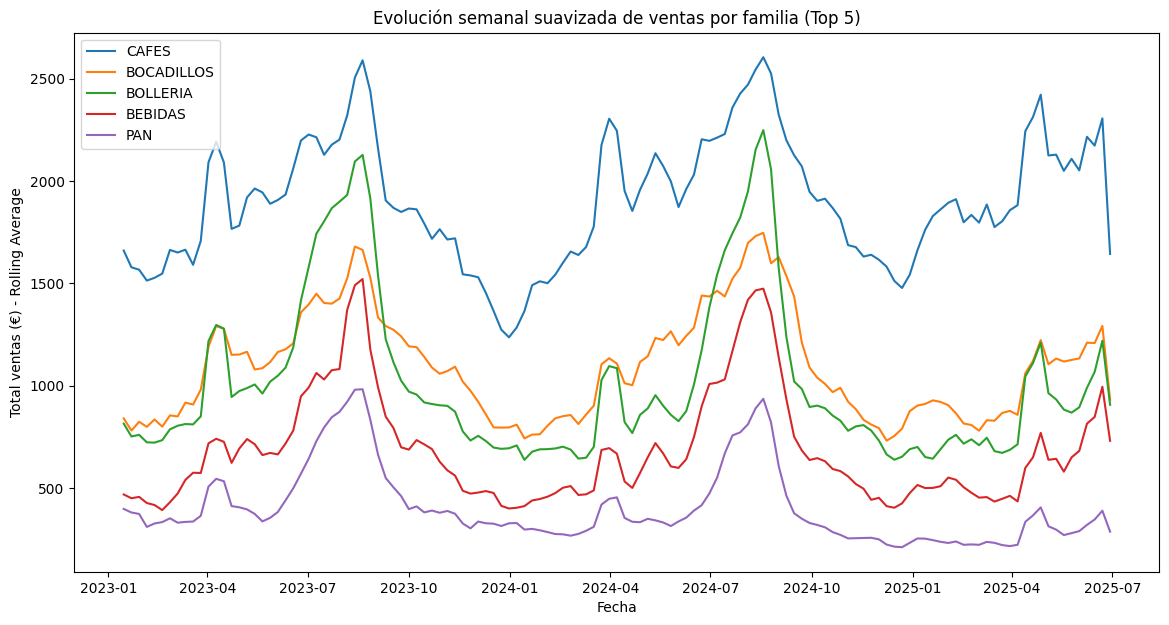

In [7]:
# Evolución semanal con Rolling Average ---
plt.figure(figsize=(14,7))
window_size = 3  # suavizado con ventana de 3 semanas

for familia in top_familias:
    df_tmp = df_semanal[df_semanal['familia'] == familia].copy()
    df_tmp = df_tmp.sort_values('fecha')
    df_tmp['total_rolling'] = df_tmp['total'].rolling(window=window_size, center=True).mean()
    plt.plot(df_tmp['fecha'], df_tmp['total_rolling'], label=familia)

plt.title('Evolución semanal suavizada de ventas por familia (Top 5)')
plt.xlabel('Fecha')
plt.ylabel('Total ventas (€) - Rolling Average')
plt.legend()
plt.show()

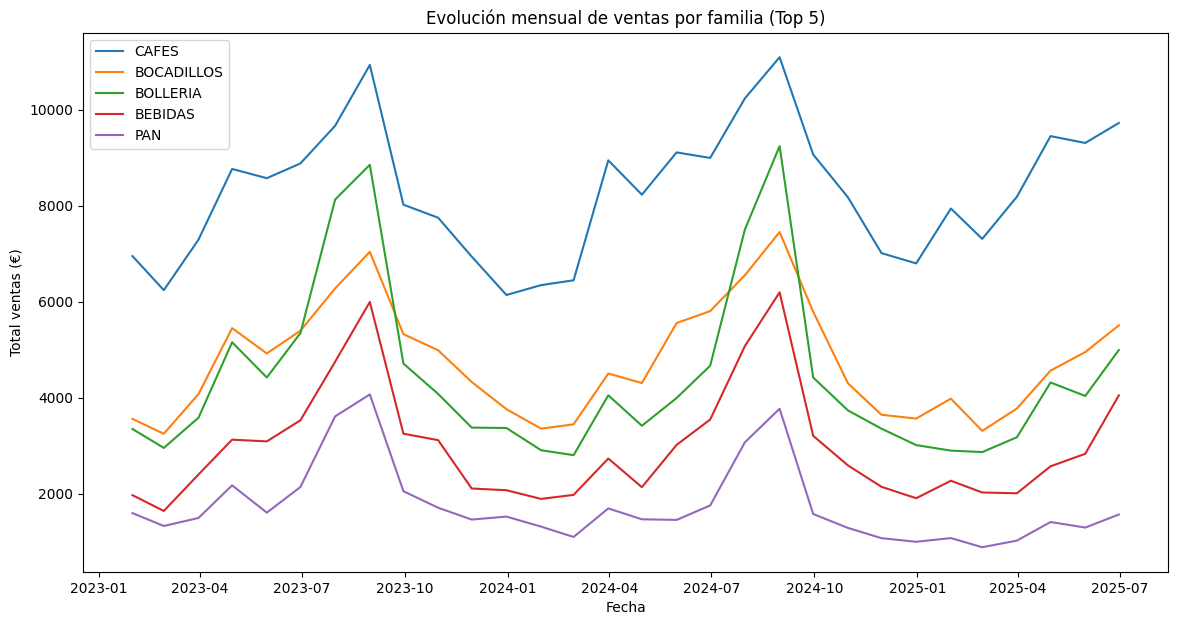

In [8]:
# --- 2) Evolución mensual por familia ---
df_mensual = dfs['df_mensual']
plt.figure(figsize=(14,7))

for familia in top_familias:
    df_tmp = df_mensual[df_mensual['familia'] == familia]
    plt.plot(df_tmp['fecha'], df_tmp['total'], label=familia)

plt.title('Evolución mensual de ventas por familia (Top 5)')
plt.xlabel('Fecha')
plt.ylabel('Total ventas (€)')
plt.legend()
plt.show()

**Insights**

- Los gráficos muestran con claridad que el comportamiento de ventas sigue un patrón estacional muy definido, especialmente en las familias con mayor volumen.

- CAFÉS es la familia líder en ventas, con una presencia estable durante todo el año y picos notables en los meses de verano (julio-agosto), pero también mantiene buenos niveles fuera de temporada alta.

- BOCADILLOS y BOLLERIA presentan un comportamiento mucho más marcado por la estacionalidad, con un crecimiento fuerte en los meses de verano y un descenso evidente en invierno.

- BEBIDAS y PAN mantienen un volumen inferior al resto, aunque también con una ligera tendencia ascendente en el verano, pero con menos amplitud en la variación.

- En todos los casos se observa que el verano es el periodo de máxima actividad, seguido de un repunte menos intenso en Semana Santa. La evolución es consistente entre años, lo que refuerza la hipótesis de que el turismo es el principal motor de ventas estacionales.

- Además, la estabilidad en CAFÉS sugiere que este producto tiene una demanda más regular asociada tanto a turismo como al consumo local habitual.

**Conclusión**

Este comportamiento refuerza la importancia de:

- Incluir la variable estacional verano como predictor en modelos de forecasting.

- Tener en cuenta la familia de producto en la predicción, ya que la sensibilidad a la estacionalidad no es igual para todas.

## Distribución acumulada ventas por familias

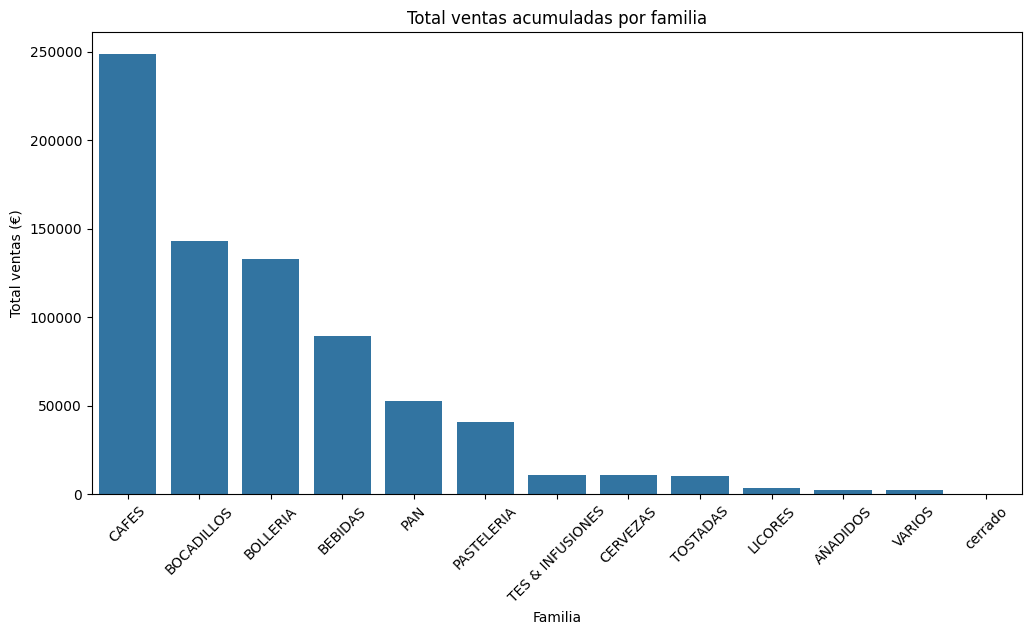

In [9]:
# Distribución acumulada de ventas por familia
df_familia_total = df_semanal.groupby('familia')['total'].sum().reset_index().sort_values('total', ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(data=df_familia_total, x='familia', y='total')
plt.title('Total ventas acumuladas por familia')
plt.xticks(rotation=45)
plt.xlabel('Familia')
plt.ylabel('Total ventas (€)')
plt.show()

**Insights**

- CAFÉS es, con mucha diferencia, la categoría dominante. Esto confirma su importancia estratégica tanto para el forecasting como para la gestión del negocio. Es la familia con más estabilidad y volumen anual.

- Le siguen BOCADILLOS y BOLLERIA, que son también muy relevantes pero con un volumen conjunto que apenas iguala al de CAFÉS.

- BEBIDAS y PAN completan el top 5 pero con un volumen significativamente menor, lo que indica que tienen un peso menor en la facturación total.

- El resto de categorías, como PASTELERIA, TES & INFUSIONES, CERVEZAS, TOSTADAS, LICORES, AÑADIDOS y VARIOS, tienen un impacto marginal en la facturación global.

**Conclusiones**

- El modelo de forecasting debería empezar priorizando CAFÉS, seguido por BOCADILLOS y BOLLERIA, por su peso relativo.

- Las demás categorías podrían integrarse en un forecasting agregado o explorarse solo si el negocio quiere profundizar en nichos concretos.


## Evolución semanal por familias en facetas

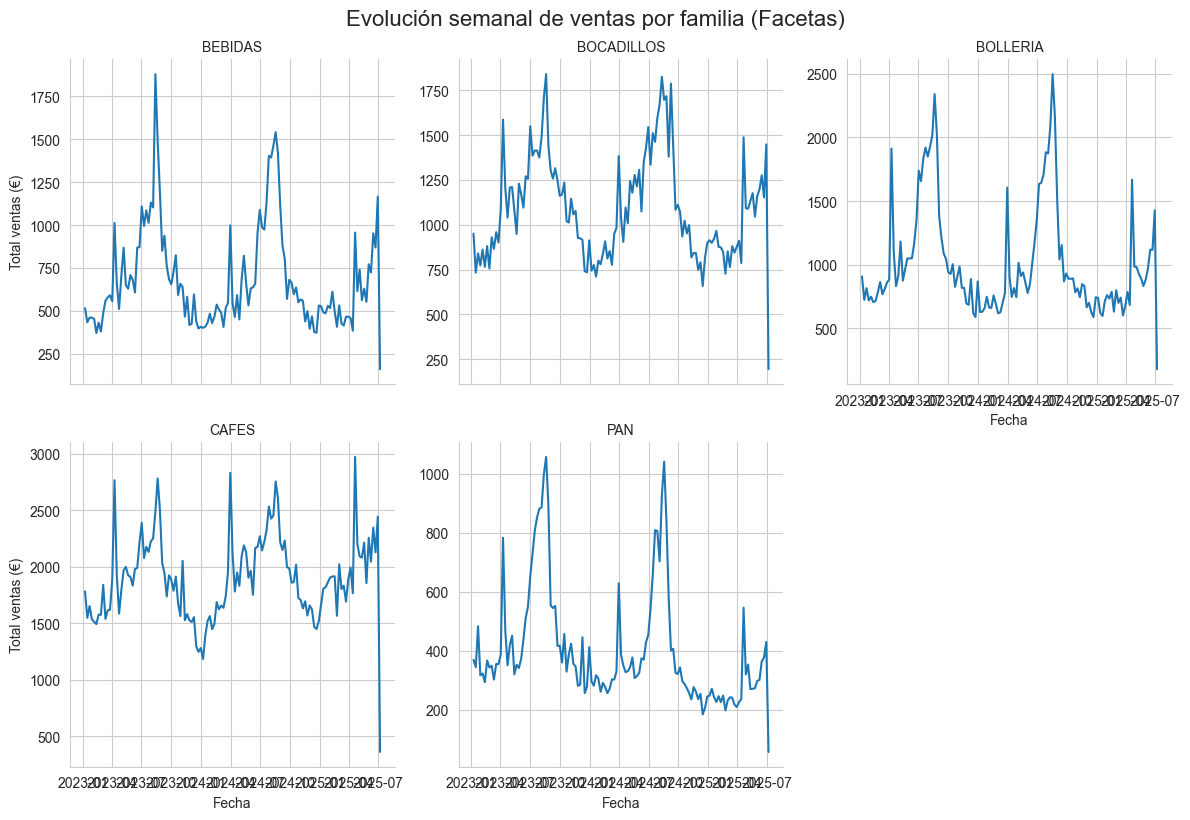

In [10]:
# Evolución semanal para cada familia en Facetas
sns.set_style("whitegrid")
g = sns.FacetGrid(
    df_semanal[df_semanal['familia'].isin(top_familias)],
    col="familia", col_wrap=3, height=4, sharey=False
)
g.map_dataframe(sns.lineplot, x='fecha', y='total')
g.set_axis_labels("Fecha", "Total ventas (€)")
g.set_titles(col_template="{col_name}")
g.fig.suptitle('Evolución semanal de ventas por familia (Facetas)', fontsize=16, y=1.02)
plt.show()

**Insights**

Este gráfico de facetas por familia complementa la exploración del análisis por familias.

- **CAFÉS:** Confirma un volumen sostenido todo el año con picos pronunciados en verano y, en menor medida, en Semana Santa. Es la categoría más estable, ideal para un forecasting regular.

- **BOCADILLOS y BOLLERIA:** Ambas presentan un patrón estacional muy claro, con subidas marcadas en verano. Su volumen fuera de temporada cae de forma más acusada que en CAFÉS.

- **BEBIDAS:** Tiene también un comportamiento estacional, pero además muestra picos aislados que podrían responder a eventos concretos, promociones o climatología.

- **PAN:** Es la familia más plana, con menor volumen. Aunque también crece en verano, la diferencia respecto al resto del año es menos pronunciada en términos relativos.

**Conclusiones**

El ritmo y pendiente de subida en verano varía entre familias, lo que sugiere que un modelo único para todas las familias podría ser poco eficaz.

## Evolución del comportamiento por día de la semana

C:\Users\jordi\AppData\Local\Temp\ipykernel_2068\864398463.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


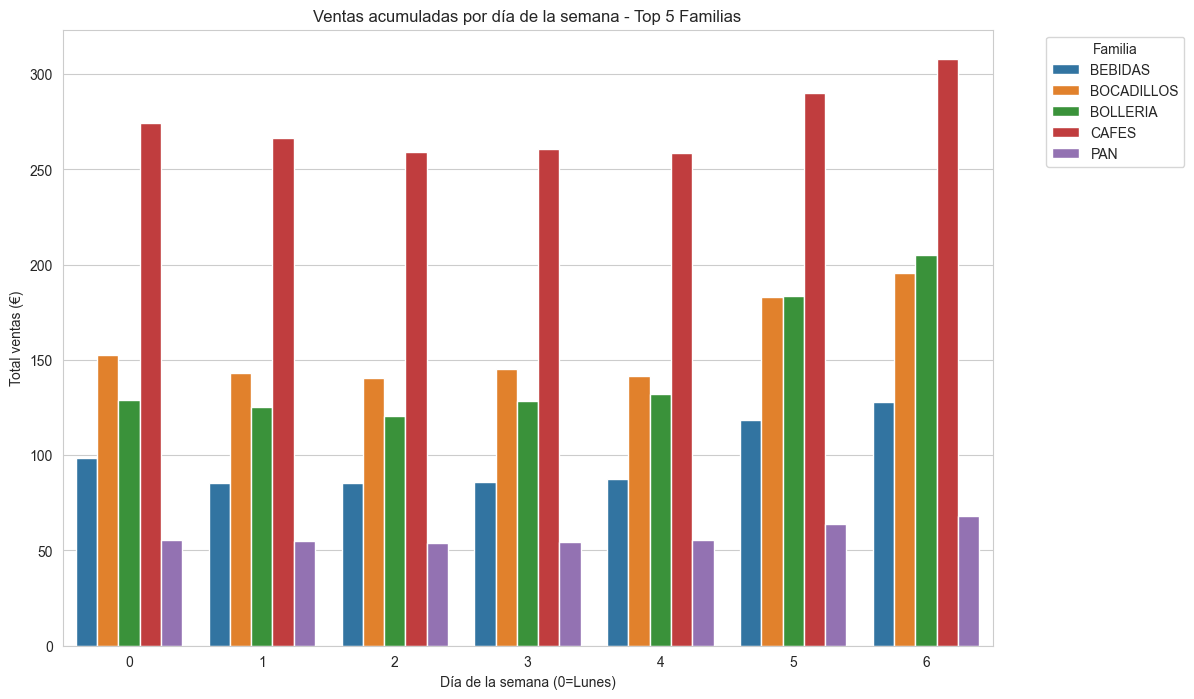

In [11]:
# --- Análisis del comportamiento por día de la semana por familia ---
df_diario = dfs['df_diario']

# Identificar el top 5 de familias por ventas acumuladas
top_familias = (
    df_diario.groupby('familia')['total'].sum()
    .sort_values(ascending=False)
    .head(5)
    .index.tolist()
)

plt.figure(figsize=(12,8))
sns.barplot(
    data=df_diario[df_diario['familia'].isin(top_familias)],
    x='day_of_week',
    y='total',
    hue='familia',
    ci=None
)
plt.title('Ventas acumuladas por día de la semana - Top 5 Familias')
plt.xlabel('Día de la semana (0=Lunes)')
plt.ylabel('Total ventas (€)')
plt.legend(title='Familia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Insights:**

- CAFÉS lidera claramente todos los días de la semana, lo que confirma que es un producto de consumo estable y recurrente.

- Hay un incremento en las ventas de todas las familias los fines de semana (sábado=5, domingo=6).

- El pico más alto en todas las familias ocurre el domingo, lo que refuerza la importancia del fin de semana en el negocio.

- BOCADILLOS y BOLLERIA tienen un aumento más acentuado el sábado y domingo, probablemente por el aumento de desayunos y comidas rápidas en esos días.

- BEBIDAS y PAN también crecen en fin de semana, pero con menor intensidad.

**Conclusión**

- El día de la semana es claramente un driver de ventas, especialmente en el fin de semana.

- Esto es relevante tanto para el forecasting (debería incluirse como variable categórica o codificada cíclicamente) como para la gestión operativa del negocio (personal, stock, promociones).

C:\Users\jordi\AppData\Local\Temp\ipykernel_2068\787448906.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


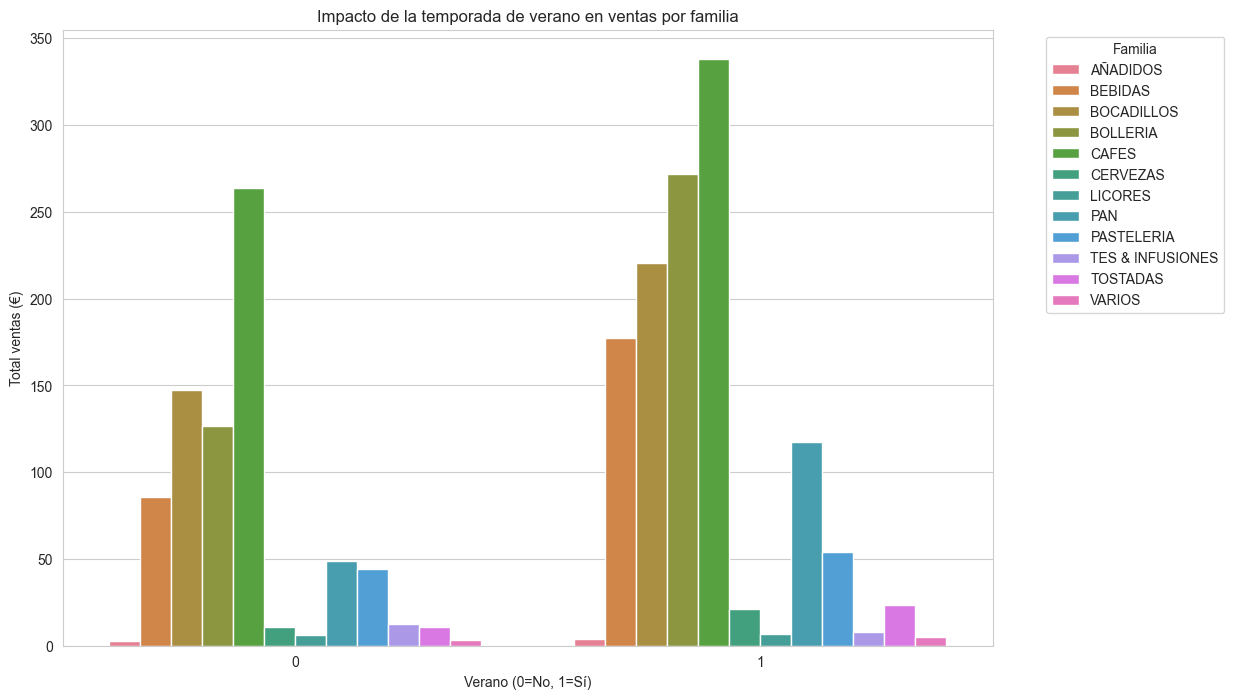

In [12]:
# --- Exploración de la relación con variables exógenas ---
df_diario = dfs['df_diario']

# Filtrar para eliminar la categoría 'cerrado'
df_diario = df_diario[df_diario['familia'] != 'cerrado']

# 1. Impacto de is_summer_peak en ventas por familia
plt.figure(figsize=(12,8))
sns.barplot(
    data=df_diario,
    x='is_summer_peak',
    y='total',
    hue='familia',
    ci=None
)
plt.title('Impacto de la temporada de verano en ventas por familia')
plt.xlabel('Verano (0=No, 1=Sí)')
plt.ylabel('Total ventas (€)')
plt.legend(title='Familia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



**Insights**

Las familias que más incrementan en verano son claramente:

- CAFÉS, que ya es líder, aumenta considerablemente.

- BOCADILLOS y BOLLERIA, con un crecimiento evidente en verano.

- BEBIDAS y PAN también crecen, aunque en menor proporción.

- Algunas familias como CERVEZAS, LICOR, TES & INFUSIONES también suben en verano, aunque el volumen es menor.

- Familias minoritarias como AÑADIDOS, VARIOS, TOSTADAS apenas se ven afectadas por la estacionalidad de verano.

**Conclusión**

Este análisis confirma que el verano es un fuerte motor de ventas para las principales categorías, sobre todo para CAFÉS, BOCADILLOS y BOLLERIA.

Esto refuerza la necesidad de:

- Incluir la variable is_summer_peak en los modelos de forecasting.

- Y planificar campañas o aprovisionamiento reforzado en verano para esas familias.




C:\Users\jordi\AppData\Local\Temp\ipykernel_2068\35423828.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


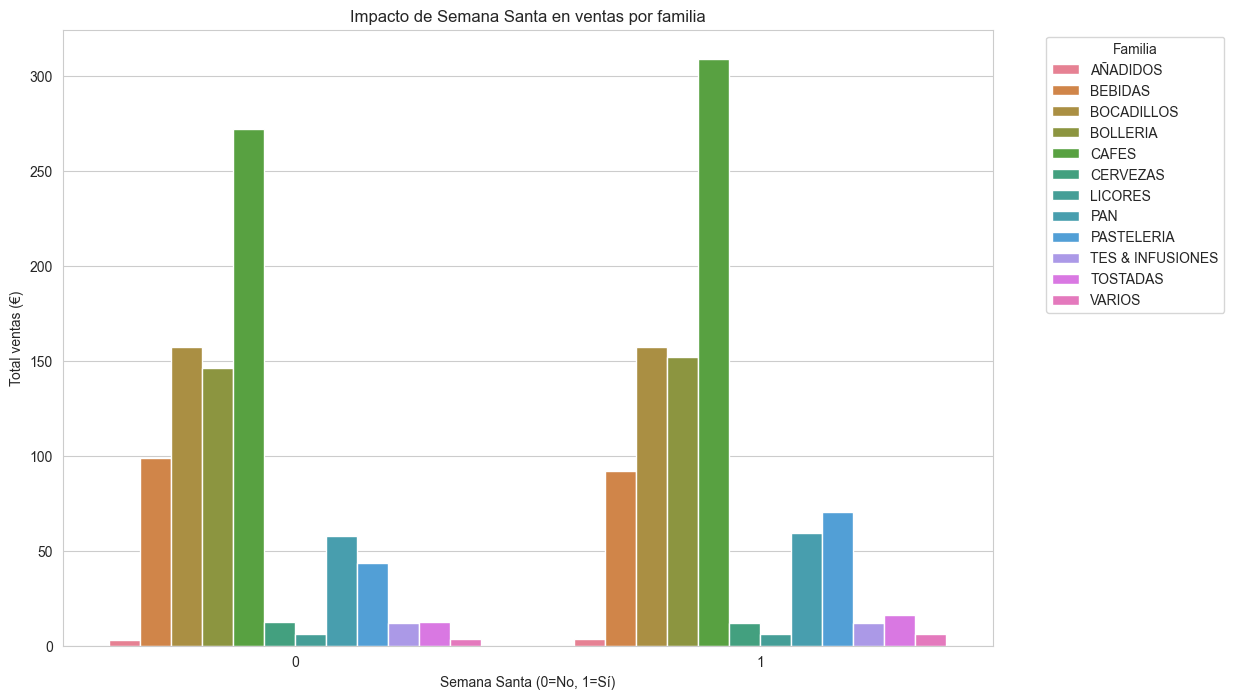

In [13]:
# 2. Impacto de is_easter en ventas por familia
plt.figure(figsize=(12,8))
sns.barplot(
    data=df_diario,
    x='is_easter',
    y='total',
    hue='familia',
    ci=None
)
plt.title('Impacto de Semana Santa en ventas por familia')
plt.xlabel('Semana Santa (0=No, 1=Sí)')
plt.ylabel('Total ventas (€)')
plt.legend(title='Familia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


**Insights**

- CAFÉS sigue siendo la familia más relevante también en Semana Santa, con un incremento moderado respecto al resto del año.

- BOCADILLOS y BOLLERIA también suben ligeramente en Semana Santa, aunque el efecto es mucho menor que en verano.

- PASTELERIA destaca más en Semana Santa que en verano, lo cual tiene sentido por el consumo de productos típicos de estas fechas.

- El resto de familias como PAN, BEBIDAS, CERVEZAS muestran variaciones menores, pero con un leve repunte.

**Conclusión**

El efecto de Semana Santa existe pero es menos potente que el de verano en términos de volumen total.

Algunas categorías específicas como PASTELERIA y CAFÉS se benefician más en estas fechas.

La variable is_easter debería incluirse en modelos de forecasting, especialmente para categorías como PASTELERIA, BOLLERIA y CAFÉS, que concentran el incremento.

# Detección y análisis de outliers

Número de outliers detectados por familia:
AÑADIDOS: 36
BEBIDAS: 28
BOCADILLOS: 26
BOLLERIA: 55
CAFES: 15
CERVEZAS: 29
LICORES: 33
PAN: 85
PASTELERIA: 46
TES & INFUSIONES: 14
TOSTADAS: 43
VARIOS: 35


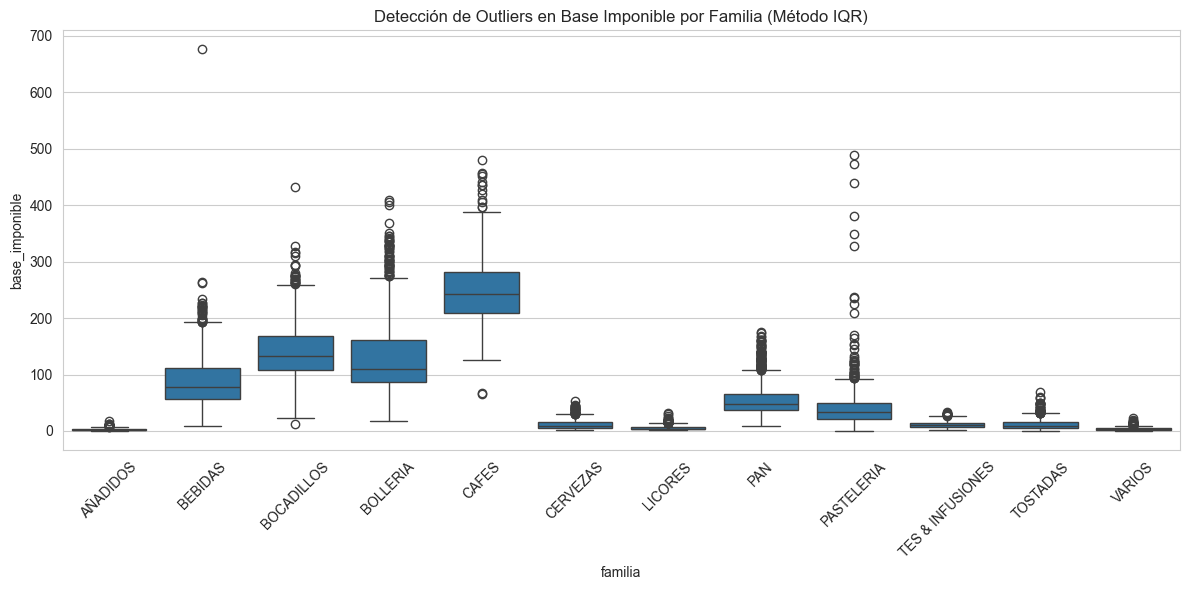

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Trabajamos sobre el df diario
df_diario = dfs['df_diario'].copy()
df_diario = df_diario[df_diario['familia'] != 'cerrado']

# Definimos función de detección de outliers usando IQR
def detectar_outliers_iqr(df, columna, familia_col='familia'):
    outliers_dict = {}
    for familia in df[familia_col].unique():
        df_fam = df[df[familia_col] == familia]
        Q1 = df_fam[columna].quantile(0.25)
        Q3 = df_fam[columna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df_fam[(df_fam[columna] < lower_bound) | (df_fam[columna] > upper_bound)]
        outliers_dict[familia] = len(outliers)
    
    return outliers_dict

# Detectamos outliers en base_imponible por familia
outliers_por_familia = detectar_outliers_iqr(df_diario, 'base_imponible')

# Visualizamos resumen
print("Número de outliers detectados por familia:")
for familia, count in outliers_por_familia.items():
    print(f"{familia}: {count}")

# Visualización con boxplots
plt.figure(figsize=(12,6))
sns.boxplot(data=df_diario, x='familia', y='base_imponible')
plt.xticks(rotation=45)
plt.title('Detección de Outliers en Base Imponible por Familia (Método IQR)')
plt.tight_layout()
plt.show()

df_diario cargado con éxito: ../data/interim/validated_range_fecha_familia_20250630.parquet - Número de filas: 9989
df_semanal cargado con éxito: ../data/interim/validated_range_semanal_familia_20250630.parquet - Número de filas: 1678
Archivo no encontrado: ../data/interim/validated_range_mensual_familia_20250630.parquet
CAFES: 15 outliers detectados


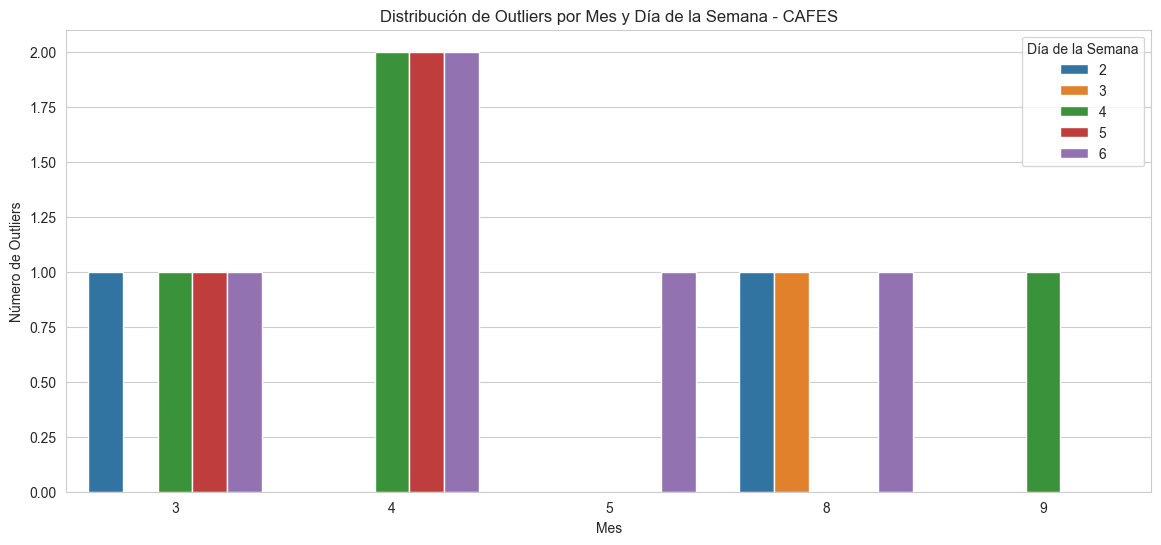

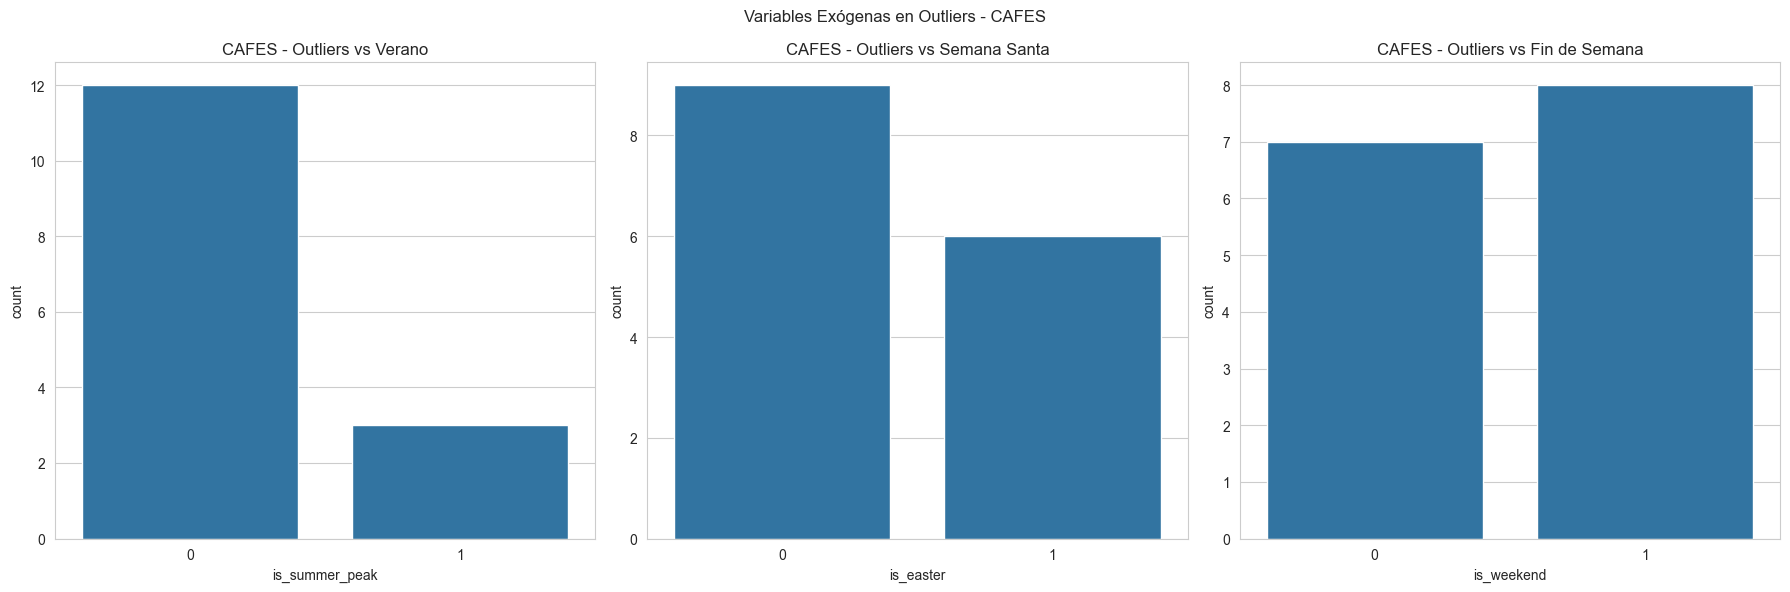

BOCADILLOS: 26 outliers detectados


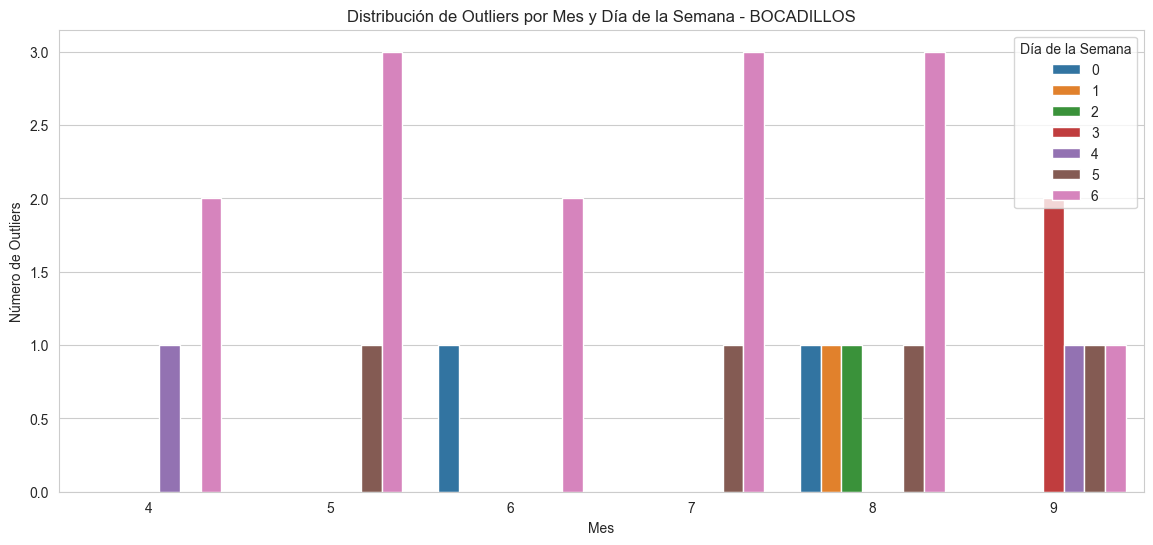

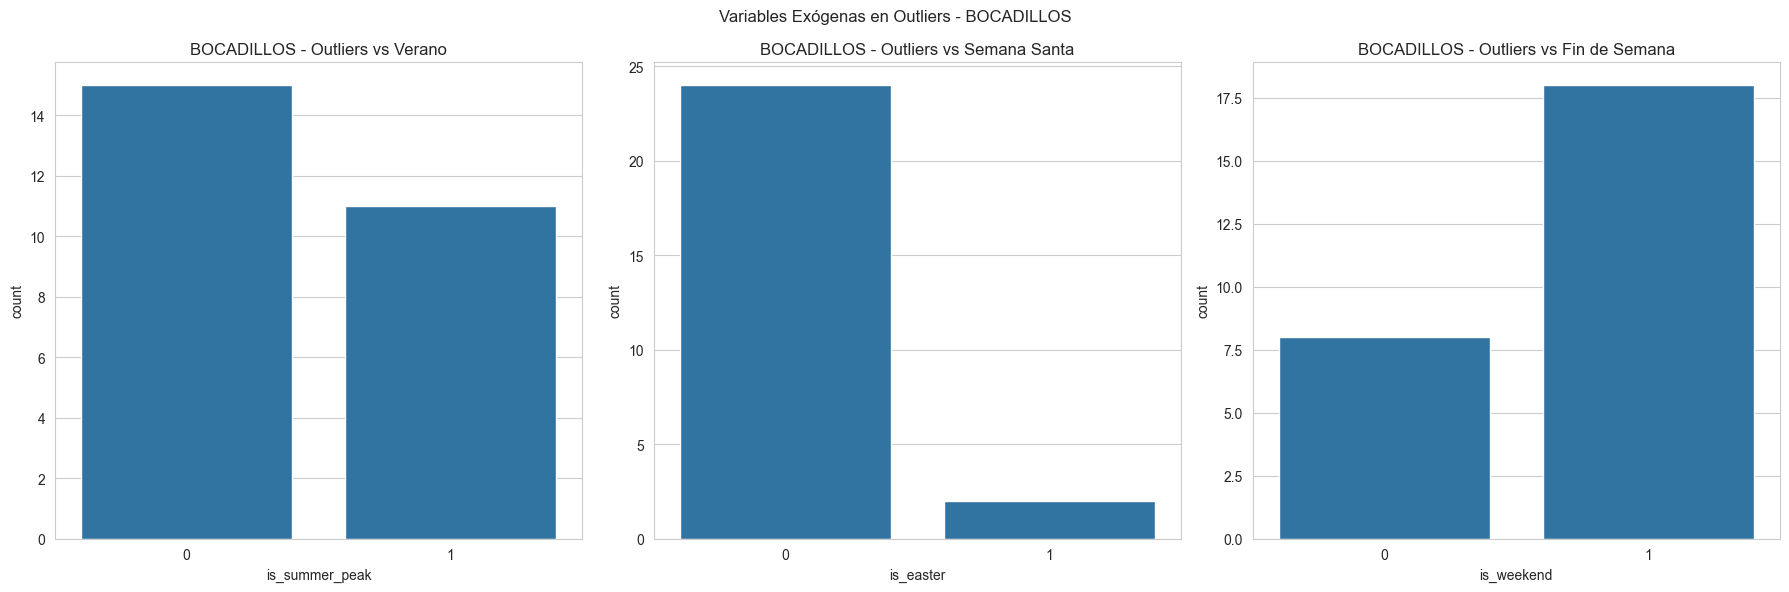

BOLLERIA: 55 outliers detectados


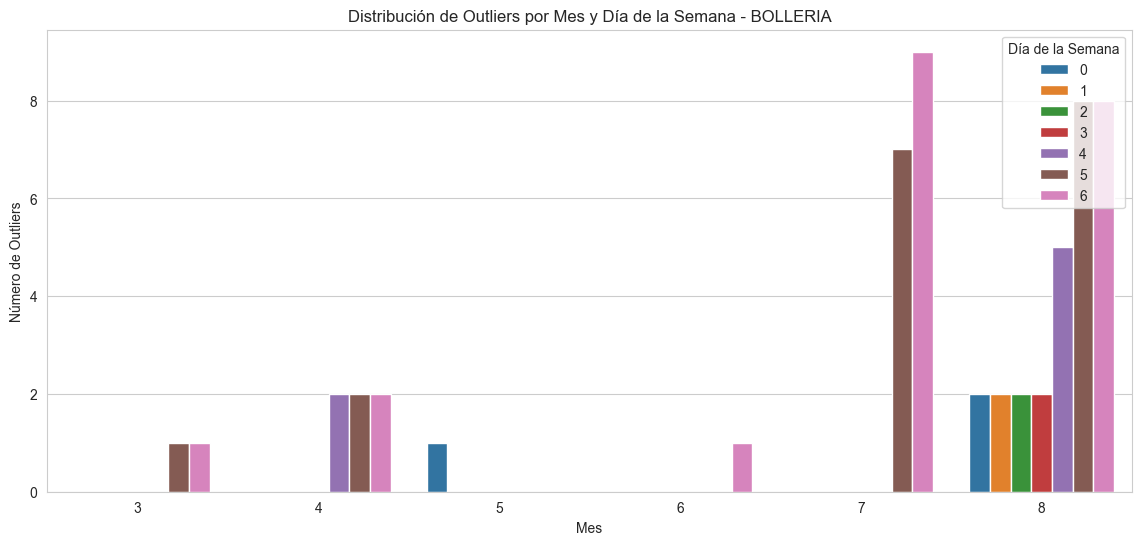

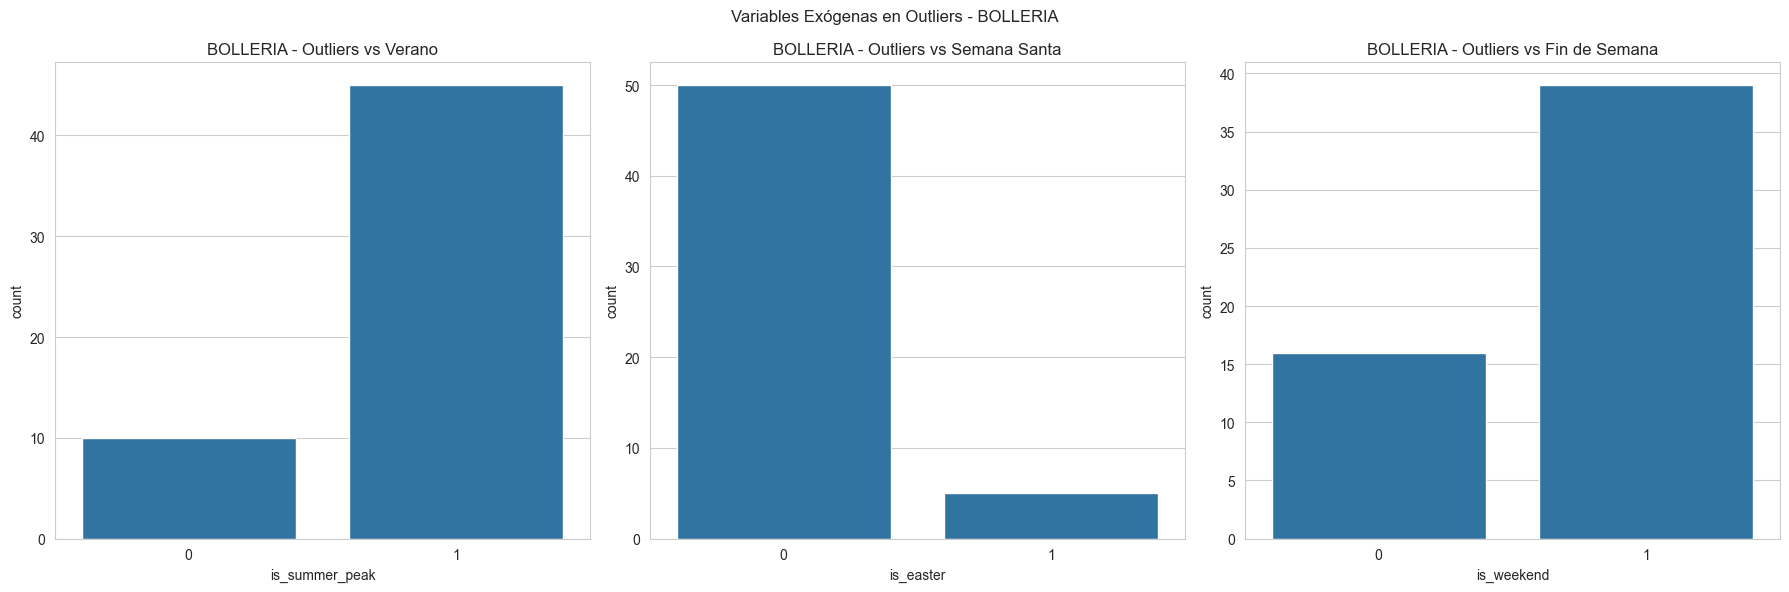

BEBIDAS: 28 outliers detectados


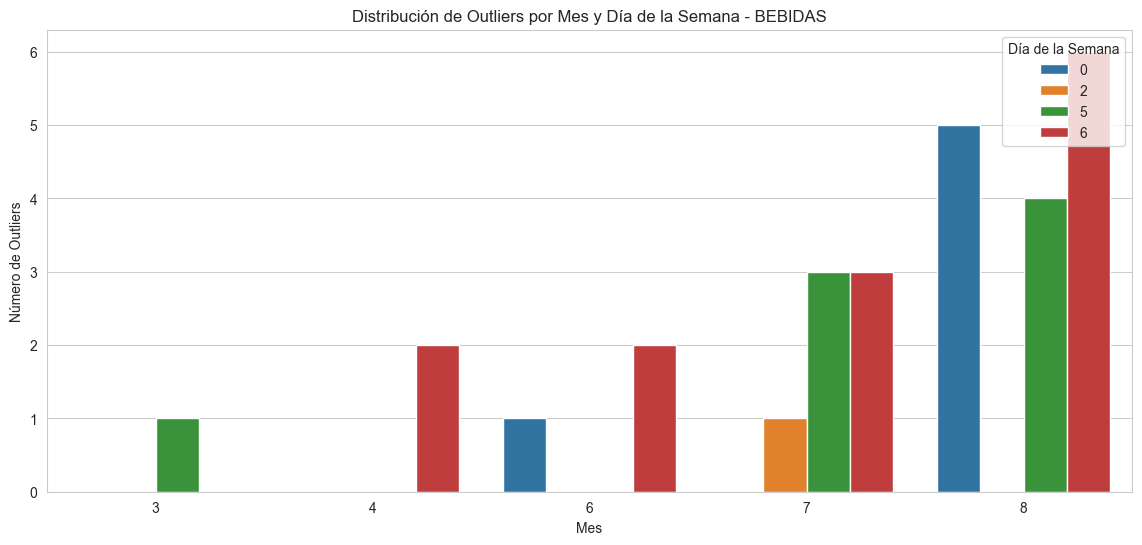

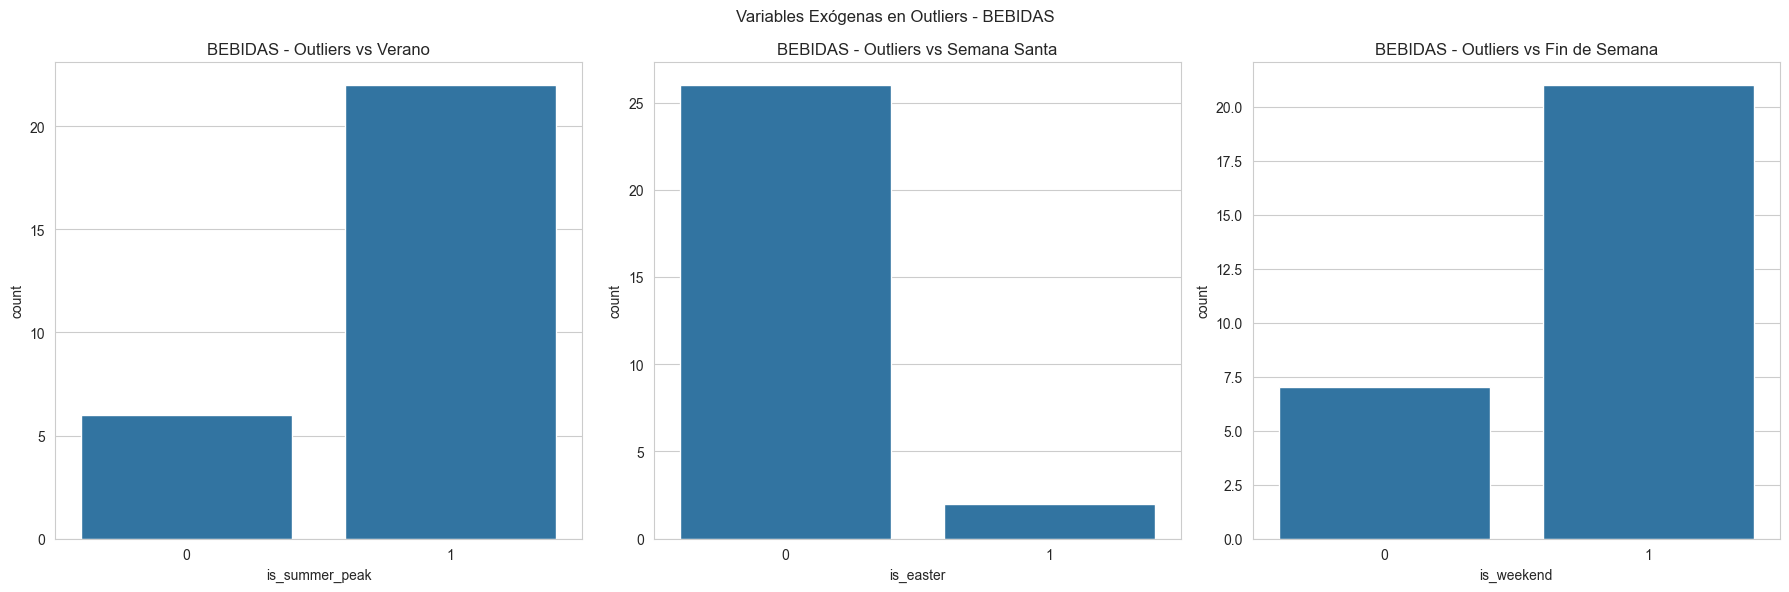

PAN: 85 outliers detectados


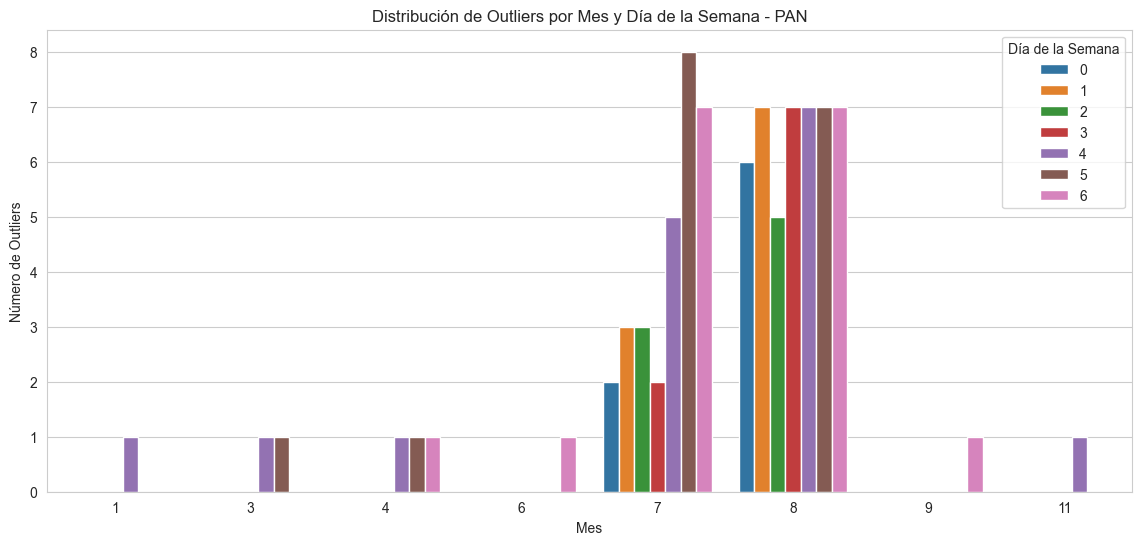

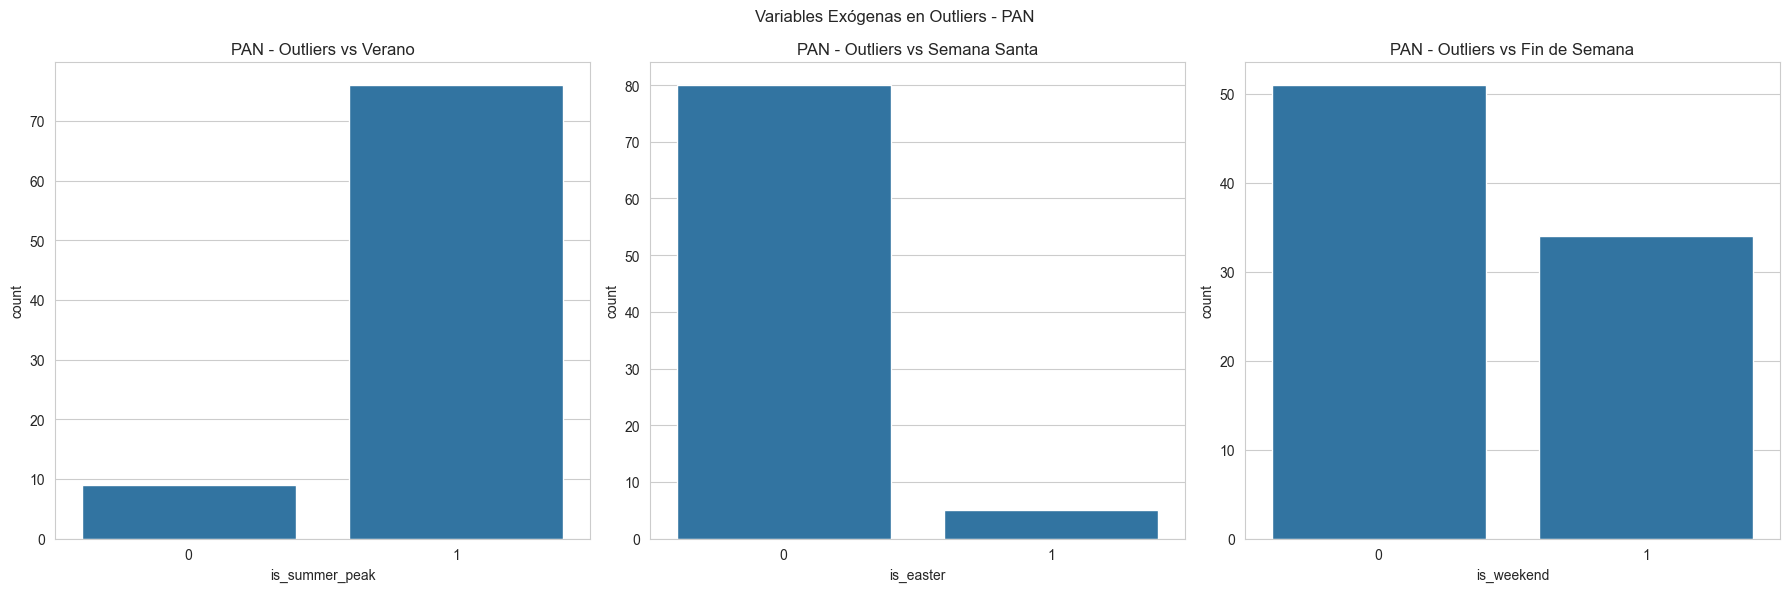

PASTELERIA: 46 outliers detectados


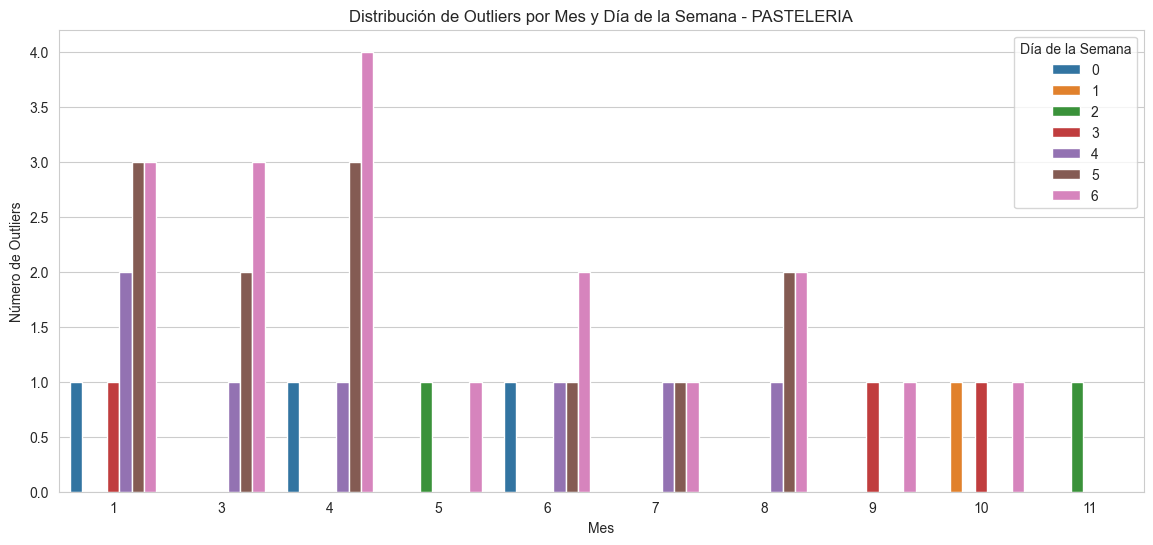

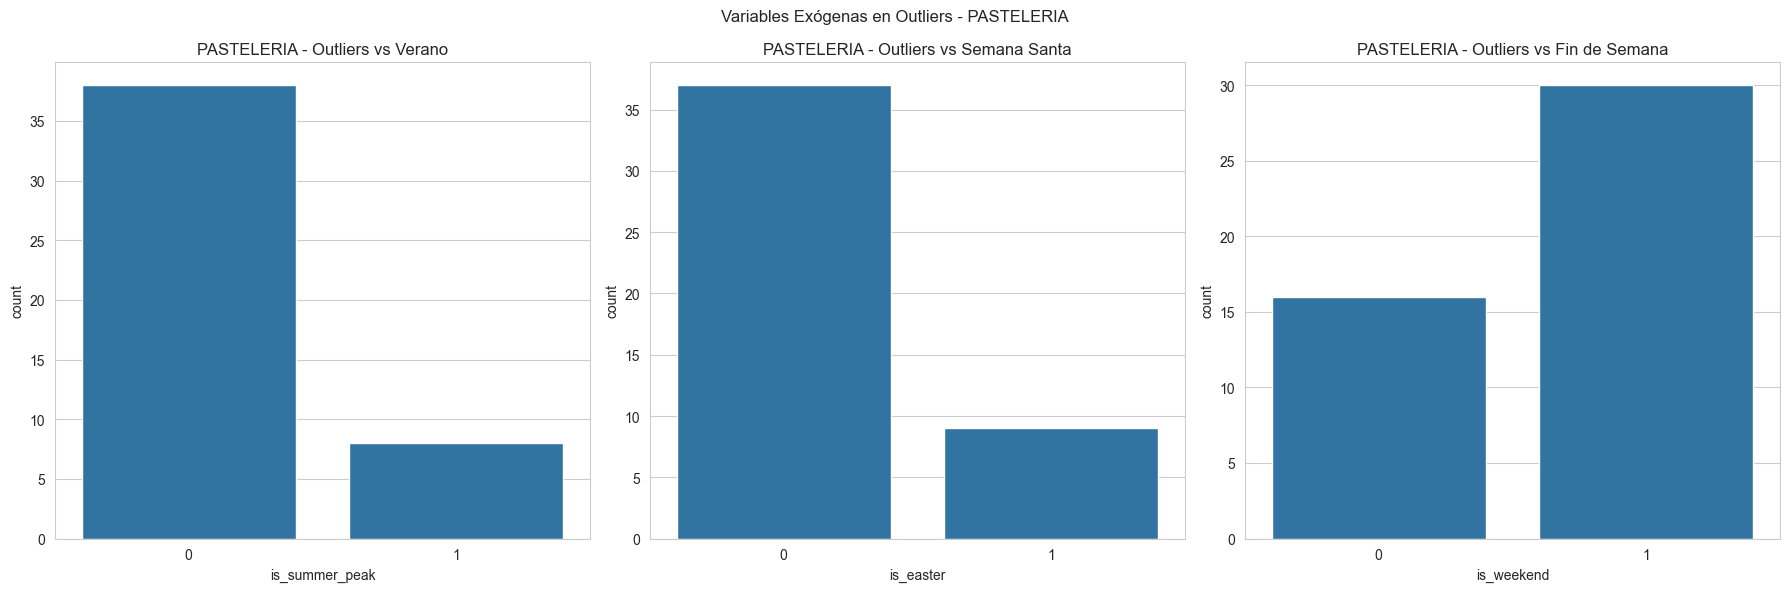

In [15]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

# --- Carga de archivos preprocesados ---
archivos = [
    "../data/interim/validated_range_fecha_familia_20250630.parquet",
    "../data/interim/validated_range_semanal_familia_20250630.parquet",
    "../data/interim/validated_range_mensual_familia_20250630.parquet"
]

nombres = ['df_diario', 'df_semanal', 'df_mensual']
dfs = {}

for archivo, nombre in zip(archivos, nombres):
    if os.path.exists(archivo):
        dfs[nombre] = pd.read_parquet(archivo)
        print(f"{nombre} cargado con éxito: {archivo} - Número de filas: {len(dfs[nombre])}")
    else:
        print(f"Archivo no encontrado: {archivo}")

# --- Preparación de datos ---
df_diario = dfs['df_diario']
df_diario = df_diario[df_diario['familia'] != 'cerrado']

# --- Identificación de outliers por familia (Top 5 + Pastelería) ---
familias_objetivo = ['CAFES', 'BOCADILLOS', 'BOLLERIA', 'BEBIDAS', 'PAN', 'PASTELERIA']
outliers_info = {}

for familia in familias_objetivo:
    df_fam = df_diario[df_diario['familia'] == familia]
    q1 = df_fam['base_imponible'].quantile(0.25)
    q3 = df_fam['base_imponible'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = df_fam[(df_fam['base_imponible'] < lower_bound) | (df_fam['base_imponible'] > upper_bound)]
    outliers_info[familia] = outliers

    print(f"{familia}: {len(outliers)} outliers detectados")

    # Visualización por mes y día de la semana
    plt.figure(figsize=(14,6))
    sns.countplot(data=outliers, x='month', hue='day_of_week', palette='tab10')
    plt.title(f'Distribución de Outliers por Mes y Día de la Semana - {familia}')
    plt.xlabel('Mes')
    plt.ylabel('Número de Outliers')
    plt.legend(title='Día de la Semana', loc='upper right')
    plt.show()

    # Visualización por variables exógenas
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    sns.countplot(data=outliers, x='is_summer_peak', ax=axes[0])
    axes[0].set_title(f'{familia} - Outliers vs Verano')

    sns.countplot(data=outliers, x='is_easter', ax=axes[1])
    axes[1].set_title(f'{familia} - Outliers vs Semana Santa')

    sns.countplot(data=outliers, x='is_weekend', ax=axes[2])
    axes[2].set_title(f'{familia} - Outliers vs Fin de Semana')

    plt.suptitle(f'Variables Exógenas en Outliers - {familia}')
    plt.tight_layout()
    plt.show()


### Conclusiones sobre la Detección y Análisis de Outliers

La detección de outliers en la variable **Base Imponible** por familia revela patrones diferenciados que aportan contexto adicional al análisis exploratorio, especialmente en relación con la estacionalidad y el comportamiento semanal:

---

#### 1. Carácter Estacional y de Ocio en Outliers
- **BEBIDAS**, **BOLLERIA** y en menor medida **BOCADILLOS** presentan outliers fuertemente asociados a los meses de **verano (julio-agosto)**, concentrándose en **fines de semana**.
- Este patrón evidencia un comportamiento típico de productos de **consumo recreativo**, intensificado en periodos de ocio y vacaciones.
- Los gráficos de violín muestran que el rango de ventas en verano es considerablemente más amplio para estas familias, reforzando la sensibilidad de estos productos al entorno estacional.

#### 2. PAN: Un Caso de Estacionalidad Extrema
- **PAN** destaca por ser la familia con mayor número de outliers, casi todos concentrados en **verano**, aunque su dispersión a lo largo de la semana es más uniforme.
- Esto sugiere que más allá de los fines de semana, el **consumo turístico o estival generalizado** genera incrementos puntuales de ventas de pan, probablemente asociado al aumento de población en la zona durante el verano.

#### 3. CAFÉS: Un Producto Regular con Picos Puntuales
- En **CAFÉS**, los outliers no muestran una concentración clara en verano o fines de semana.
- Aunque existe cierta presencia en marzo-abril y algunos fines de semana, los picos parecen deberse más a **eventos o circunstancias específicas** no capturadas por las variables exógenas analizadas.

#### 4. PASTELERÍA: Outliers Dispersos y Fechas Especiales
- **PASTELERÍA** presenta outliers repartidos a lo largo del año, con algunos repuntes en **enero, abril y noviembre**.
- Este comportamiento sugiere la influencia de **fechas especiales o celebraciones puntuales** más que de la estacionalidad turística o de ocio.

---

### Implicaciones para la Modelización
- Estos patrones son relevantes para la futura **ingeniería de características**, ya que sugieren que el componente estacional y los fines de semana deben ser modelados especialmente para familias recreativas.
- En familias como **CAFÉS** o **PASTELERÍA**, podría explorarse la inclusión de **variables externas adicionales** (festividades locales, eventos) para captar esos picos no explicados por las variables exógenas actuales.
- En la preparación del dataset para forecasting, la **gestión de outliers debe ser específica por familia**, evitando un enfoque genérico que podría distorsionar la dinámica real de consumo.


# Análisis de las variables exógenas.



Porcentaje de incremento medio en verano por familia:
familia
AÑADIDOS             47.09
BEBIDAS             106.66
BOCADILLOS           49.42
BOLLERIA            114.98
CAFES                28.13
CERVEZAS             98.43
LICORES              10.48
PAN                 140.46
PASTELERIA           22.85
TES & INFUSIONES    -38.42
TOSTADAS            111.02
VARIOS               57.89
Name: % incremento verano, dtype: float64

Porcentaje de incremento medio en Semana Santa por familia:
familia
AÑADIDOS            24.84
BEBIDAS             -6.79
BOCADILLOS          -0.26
BOLLERIA             3.91
CAFES               13.64
CERVEZAS            -2.50
LICORES             -5.69
PAN                  2.09
PASTELERIA          60.87
TES & INFUSIONES     1.33
TOSTADAS            27.11
VARIOS              76.26
Name: % incremento semana santa, dtype: float64


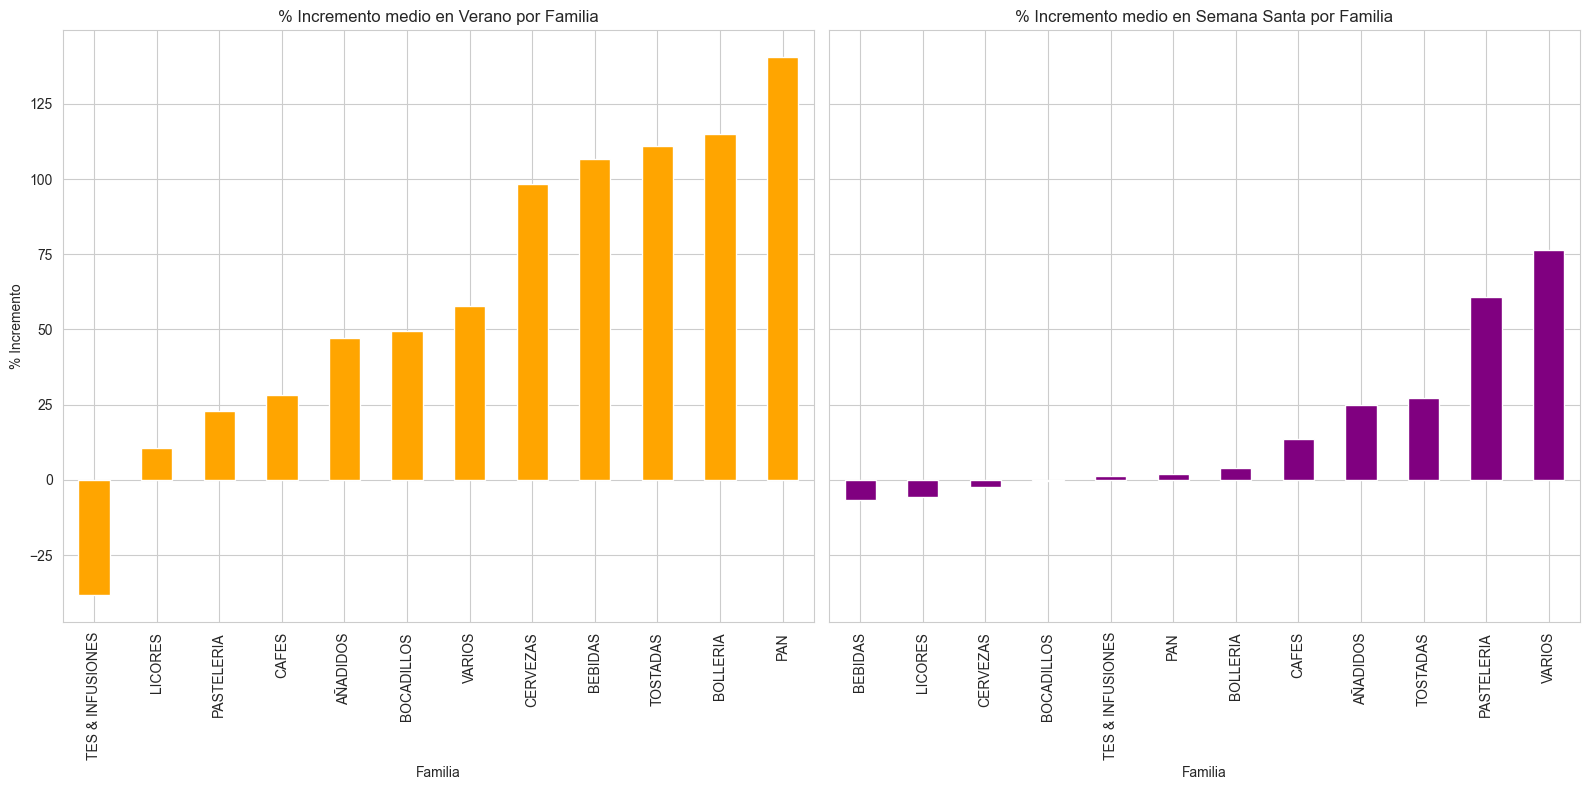

In [16]:
# --- Exploración de la relación con variables exógenas ---
df_diario = dfs['df_diario']

# Filtrar para eliminar la categoría 'cerrado'
df_diario = df_diario[df_diario['familia'] != 'cerrado']

# --- Cálculo del % incremento medio por familia en verano ---
summer_avg = df_diario.groupby(['familia', 'is_summer_peak'])['total'].mean().unstack()
summer_avg['% incremento verano'] = ((summer_avg[1] - summer_avg[0]) / summer_avg[0]) * 100

# --- Cálculo del % incremento medio por familia en Semana Santa ---
easter_avg = df_diario.groupby(['familia', 'is_easter'])['total'].mean().unstack()
easter_avg['% incremento semana santa'] = ((easter_avg[1] - easter_avg[0]) / easter_avg[0]) * 100

# --- Visualización de las tablas de porcentaje ---
print("\nPorcentaje de incremento medio en verano por familia:")
print(summer_avg['% incremento verano'].round(2))

print("\nPorcentaje de incremento medio en Semana Santa por familia:")
print(easter_avg['% incremento semana santa'].round(2))

# --- Visualización del incremento porcentual ---
fig, axes = plt.subplots(1, 2, figsize=(16,8), sharey=True)

summer_avg['% incremento verano'].sort_values().plot.bar(ax=axes[0], color='orange')
axes[0].set_title('% Incremento medio en Verano por Familia')
axes[0].set_ylabel('% Incremento')
axes[0].set_xlabel('Familia')

easter_avg['% incremento semana santa'].sort_values().plot.bar(ax=axes[1], color='purple')
axes[1].set_title('% Incremento medio en Semana Santa por Familia')
axes[1].set_ylabel('% Incremento')
axes[1].set_xlabel('Familia')

plt.tight_layout()
plt.show()


**nsights por Temporada**

***Verano (is_summer_peak)***

Las familias con mayor incremento porcentual en verano son:

* PAN (+140%): el producto que más se potencia en temporada turística.

* BOLLERIA, TOSTADAS y BEBIDAS: con incrementos superiores al 100%.

* CERVEZAS y BOCADILLOS: rondan el 50% de crecimiento.

* CAFÉS: aunque es la familia líder en ventas, su incremento es más moderado (+28%), lo que sugiere que es un consumo menos afectado por la estacionalidad.

* TES & INFUSIONES: decrecen en verano (~-38%), consistente con la menor demanda de bebidas calientes en época de calor.

***Semana Santa (is_easter)***

El impacto global es mucho menor que en verano.

Destacan:

* VARIOS y PASTELERIA: con aumentos cercanos o superiores al +75% y +40% respectivamente, probablemente por productos típicos de la fecha.

* TOSTADAS y AÑADIDOS: también se benefician, pero en menor proporción.

* La mayoría de familias tienen un impacto leve o casi nulo, e incluso BEBIDAS y CERVEZAS tienen un ligero descenso.

**Conclusiones**

- Verano es el principal impulsor de ventas, sobre todo para:

- Productos relacionados con desayunos reforzados y consumo recreativo: PAN, BOLLERIA, TOSTADAS, BEBIDAS y CERVEZAS.

- Semana Santa genera un pico, pero mucho más focalizado, especialmente en:

- PASTELERIA y algunos complementos (TOSTADAS, AÑADIDOS, VARIOS).

Esto sugiere que el forecasting debe incorporar estas dos variables exógenas, pero con diferente peso:

- is_summer_peak: crítico para la mayoría de familias.

- is_easter: relevante solo para ciertas categorías específicas.

# Análisis de correlaciones



===== Análisis para la familia: CAFES =====

Matriz de correlación:
                base_imponible  is_summer_peak  is_easter  is_weekend  \
base_imponible        1.000000        0.413626   0.140938    0.257420   
is_summer_peak        0.413626        1.000000  -0.100127   -0.003873   
is_easter             0.140938       -0.100127   1.000000   -0.004942   
is_weekend            0.257420       -0.003873  -0.004942    1.000000   
day_of_week           0.170692       -0.007514  -0.014670    0.790547   
month                 0.029600        0.185121  -0.176086    0.011157   

                day_of_week     month  
base_imponible     0.170692  0.029600  
is_summer_peak    -0.007514  0.185121  
is_easter         -0.014670 -0.176086  
is_weekend         0.790547  0.011157  
day_of_week        1.000000  0.010317  
month              0.010317  1.000000  


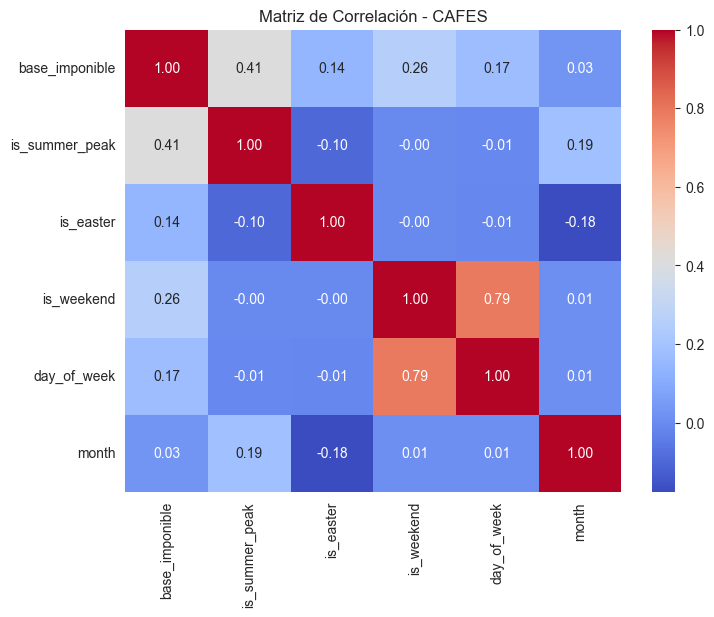

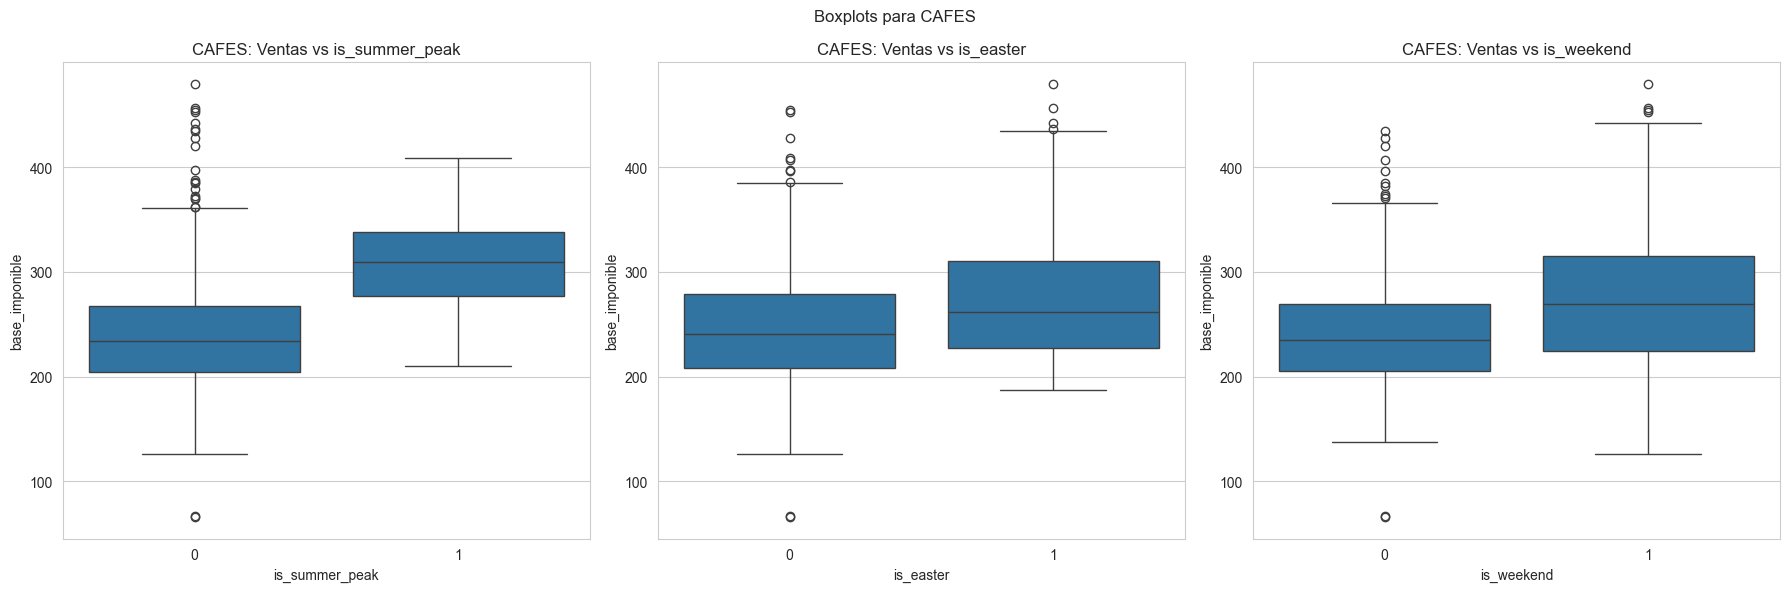



===== Análisis para la familia: BOCADILLOS =====

Matriz de correlación:
                base_imponible  is_summer_peak  is_easter  is_weekend  \
base_imponible        1.000000        0.463866  -0.002001    0.372902   
is_summer_peak        0.463866        1.000000  -0.100127   -0.003873   
is_easter            -0.002001       -0.100127   1.000000   -0.004942   
is_weekend            0.372902       -0.003873  -0.004942    1.000000   
day_of_week           0.276041       -0.007514  -0.014670    0.790547   
month                 0.187686        0.185121  -0.176086    0.011157   

                day_of_week     month  
base_imponible     0.276041  0.187686  
is_summer_peak    -0.007514  0.185121  
is_easter         -0.014670 -0.176086  
is_weekend         0.790547  0.011157  
day_of_week        1.000000  0.010317  
month              0.010317  1.000000  


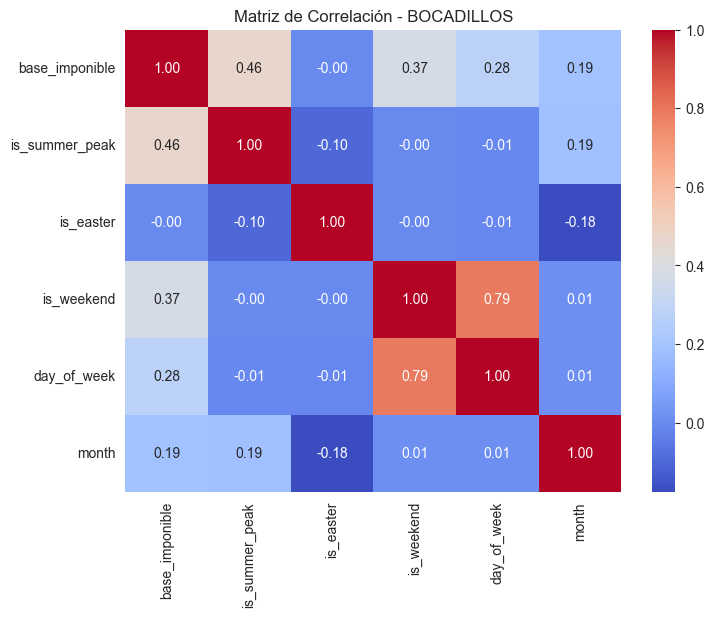

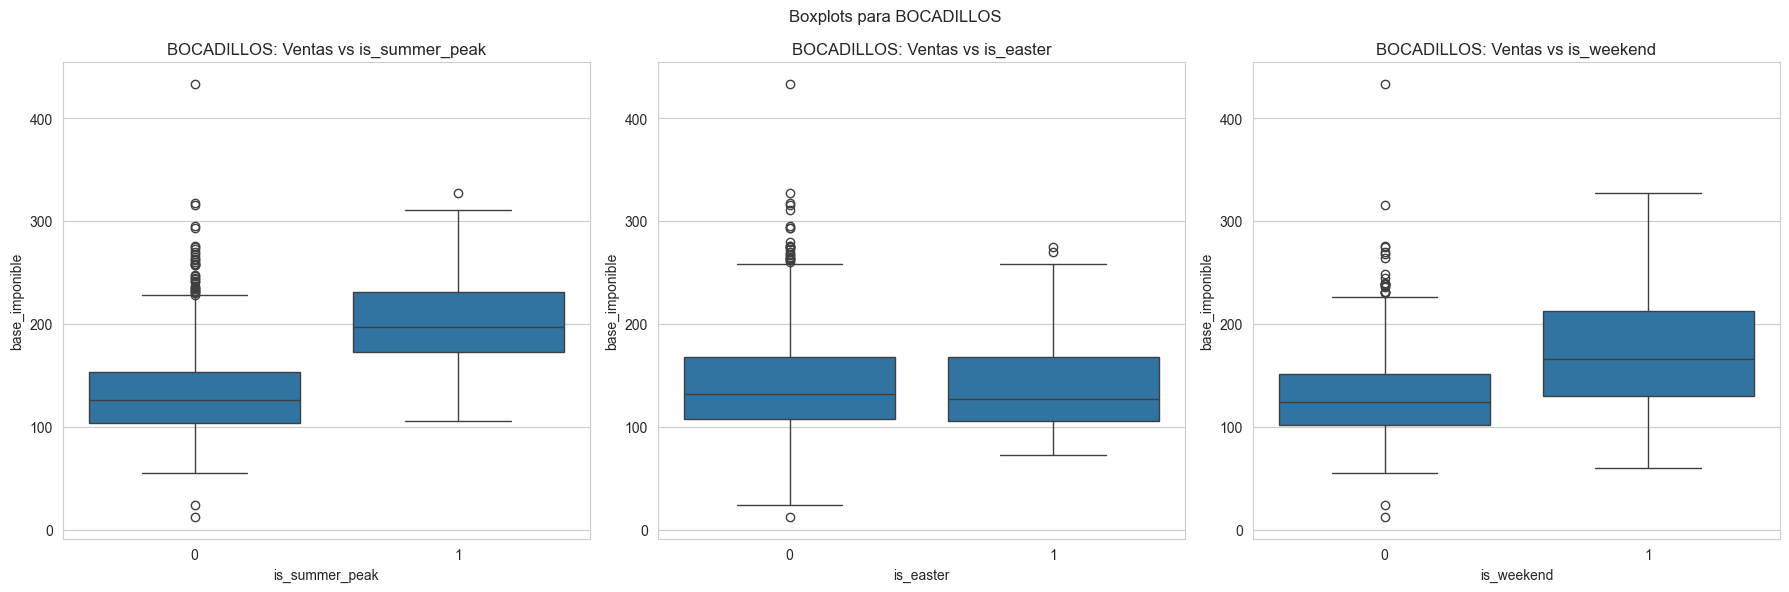



===== Análisis para la familia: BOLLERIA =====

Matriz de correlación:
                base_imponible  is_summer_peak  is_easter  is_weekend  \
base_imponible        1.000000        0.679796   0.018487    0.414507   
is_summer_peak        0.679796        1.000000  -0.100127   -0.003873   
is_easter             0.018487       -0.100127   1.000000   -0.004942   
is_weekend            0.414507       -0.003873  -0.004942    1.000000   
day_of_week           0.347578       -0.007514  -0.014670    0.790547   
month                 0.183118        0.185121  -0.176086    0.011157   

                day_of_week     month  
base_imponible     0.347578  0.183118  
is_summer_peak    -0.007514  0.185121  
is_easter         -0.014670 -0.176086  
is_weekend         0.790547  0.011157  
day_of_week        1.000000  0.010317  
month              0.010317  1.000000  


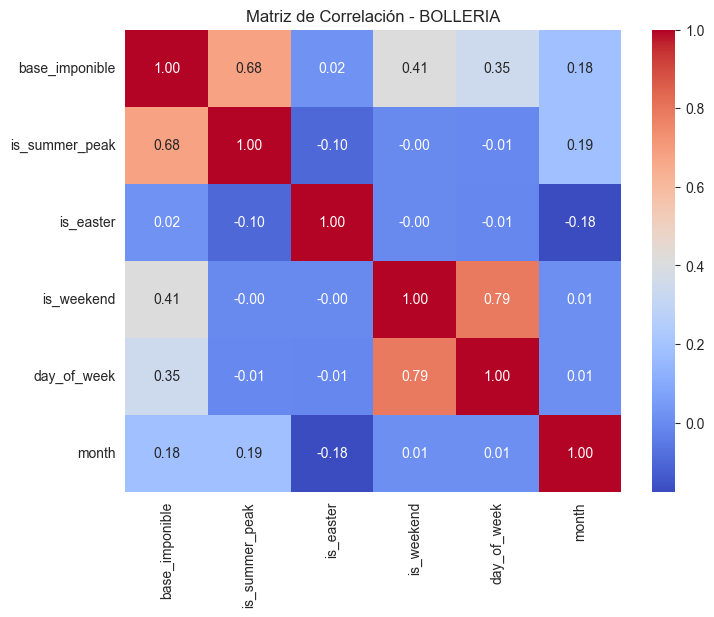

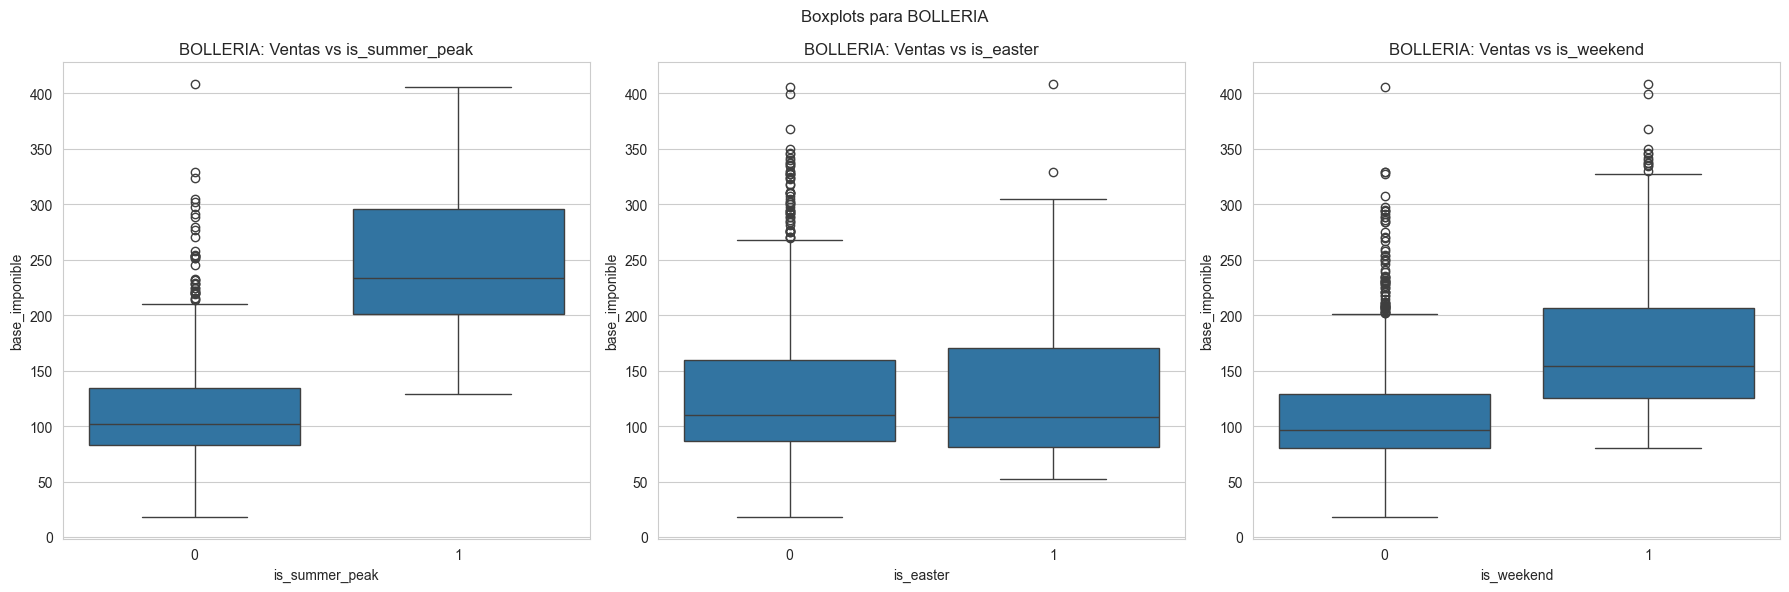



===== Análisis para la familia: BEBIDAS =====

Matriz de correlación:
                base_imponible  is_summer_peak  is_easter  is_weekend  \
base_imponible        1.000000        0.596959  -0.030506    0.294683   
is_summer_peak        0.596959        1.000000  -0.100127   -0.003873   
is_easter            -0.030506       -0.100127   1.000000   -0.004942   
is_weekend            0.294683       -0.003873  -0.004942    1.000000   
day_of_week           0.209873       -0.007514  -0.014670    0.790547   
month                 0.179611        0.185121  -0.176086    0.011157   

                day_of_week     month  
base_imponible     0.209873  0.179611  
is_summer_peak    -0.007514  0.185121  
is_easter         -0.014670 -0.176086  
is_weekend         0.790547  0.011157  
day_of_week        1.000000  0.010317  
month              0.010317  1.000000  


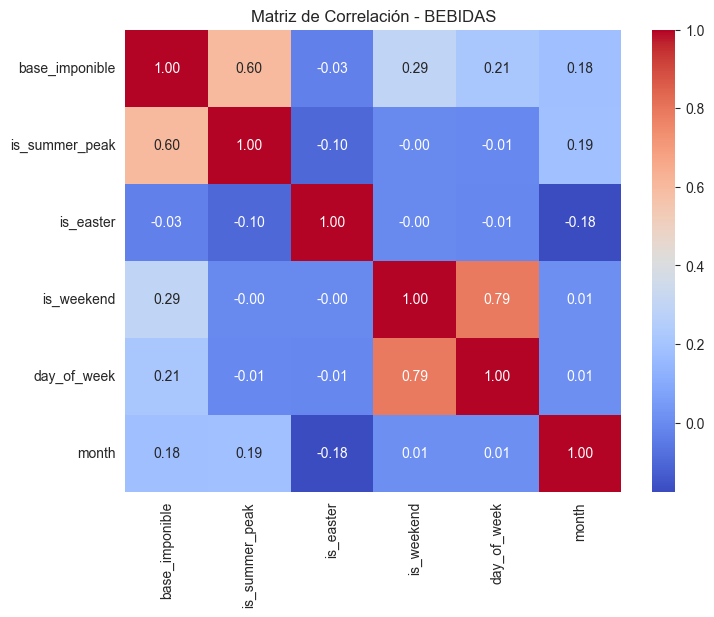

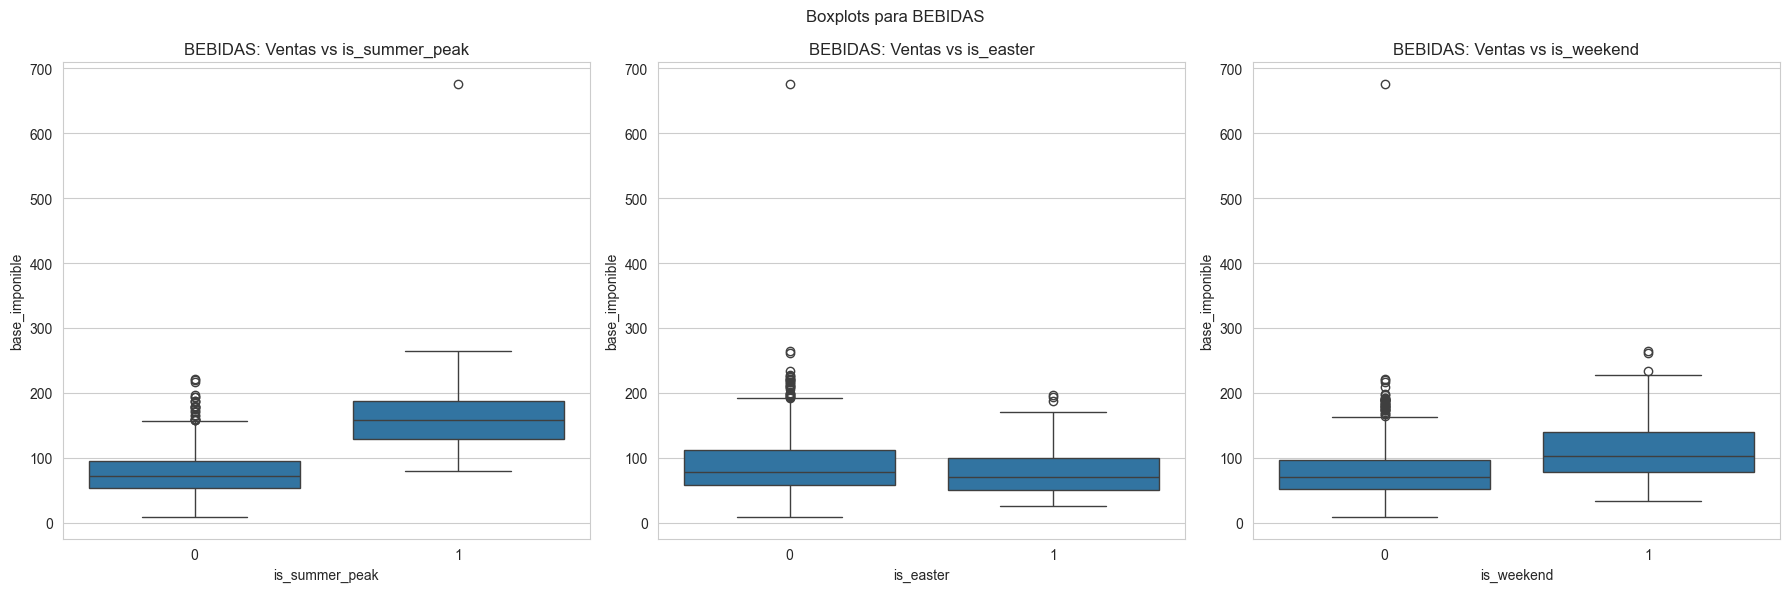



===== Análisis para la familia: PAN =====

Matriz de correlación:
                base_imponible  is_summer_peak  is_easter  is_weekend  \
base_imponible        1.000000        0.769335   0.010688    0.163928   
is_summer_peak        0.769335        1.000000  -0.100127   -0.003873   
is_easter             0.010688       -0.100127   1.000000   -0.004942   
is_weekend            0.163928       -0.003873  -0.004942    1.000000   
day_of_week           0.133739       -0.007514  -0.014670    0.790547   
month                 0.176616        0.185121  -0.176086    0.011157   

                day_of_week     month  
base_imponible     0.133739  0.176616  
is_summer_peak    -0.007514  0.185121  
is_easter         -0.014670 -0.176086  
is_weekend         0.790547  0.011157  
day_of_week        1.000000  0.010317  
month              0.010317  1.000000  


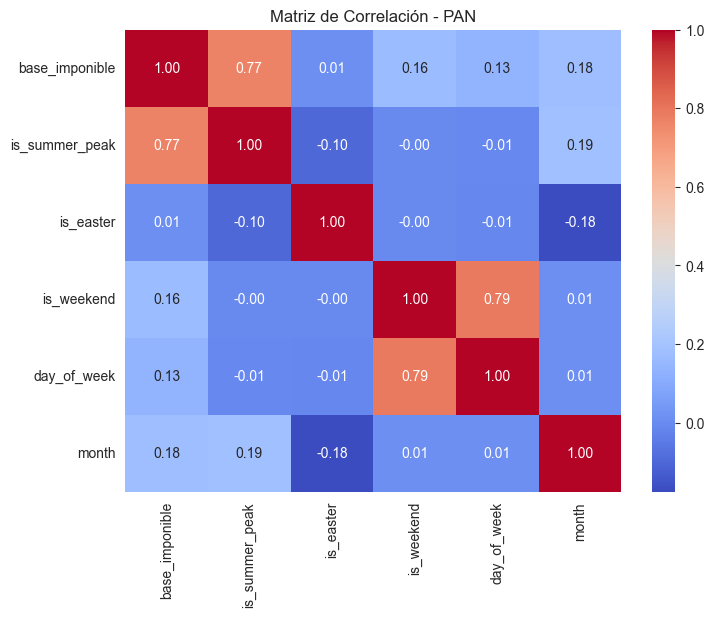

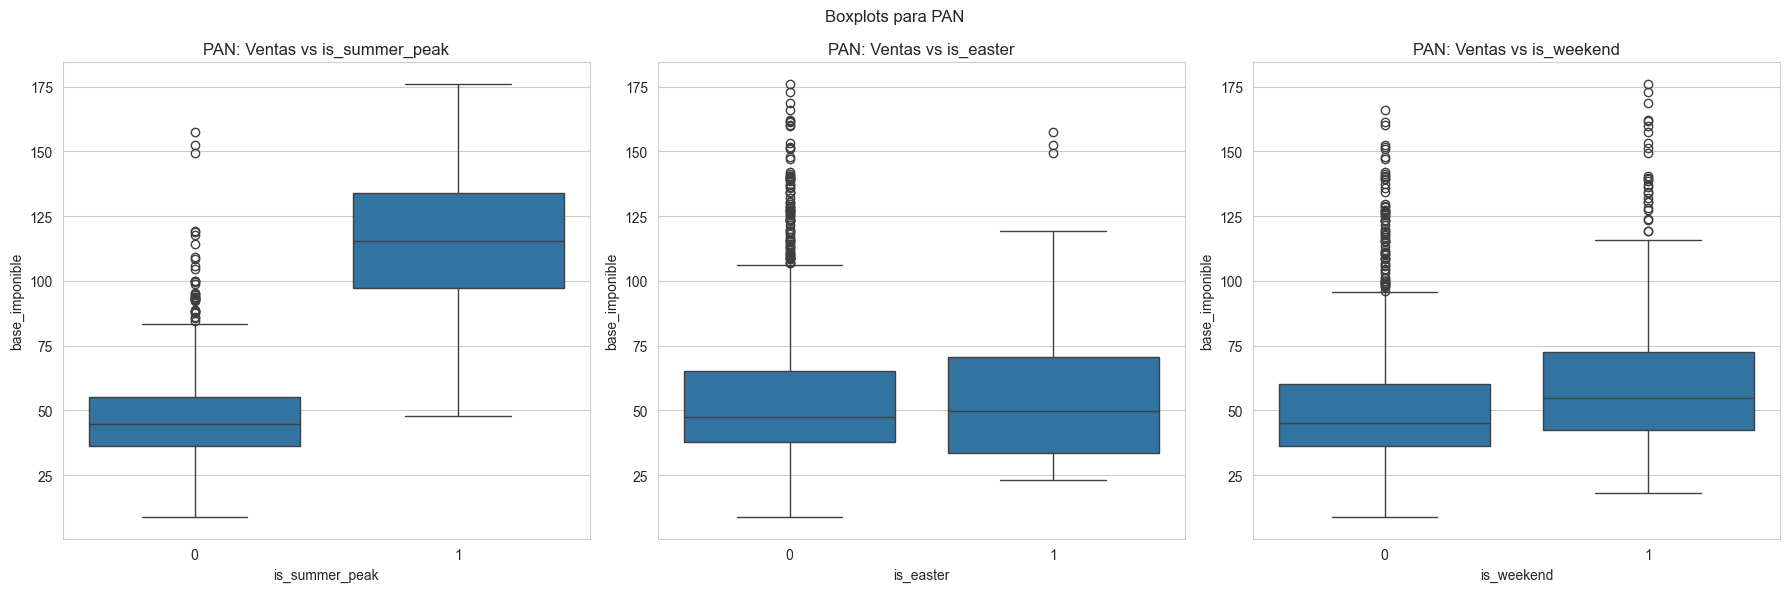

In [17]:
# --- Preparación de datos ---
df_diario = dfs['df_diario']
df_diario = df_diario[df_diario['familia'] != 'cerrado']

# --- Análisis de correlación y boxplots por familia ---
top_familias = ['CAFES', 'BOCADILLOS', 'BOLLERIA', 'BEBIDAS', 'PAN']

for familia in top_familias:
    print(f"\n\n===== Análisis para la familia: {familia} =====")
    df_fam = df_diario[df_diario['familia'] == familia]

    correlation_vars = ['base_imponible', 'is_summer_peak', 'is_easter', 'is_weekend', 'day_of_week', 'month']
    correlation_matrix = df_fam[correlation_vars].corr()

    print("\nMatriz de correlación:")
    print(correlation_matrix)

    plt.figure(figsize=(8,6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(f'Matriz de Correlación - {familia}')
    plt.show()

    # Boxplots
    fig, axes = plt.subplots(1, 3, figsize=(18,6))
    sns.boxplot(data=df_fam, x='is_summer_peak', y='base_imponible', ax=axes[0])
    axes[0].set_title(f'{familia}: Ventas vs is_summer_peak')

    sns.boxplot(data=df_fam, x='is_easter', y='base_imponible', ax=axes[1])
    axes[1].set_title(f'{familia}: Ventas vs is_easter')

    sns.boxplot(data=df_fam, x='is_weekend', y='base_imponible', ax=axes[2])
    axes[2].set_title(f'{familia}: Ventas vs is_weekend')

    plt.suptitle(f'Boxplots para {familia}')
    plt.tight_layout()
    plt.show()


### ✅ Relación de ventas (`base_imponible`) con variables exógenas en cada familia

| Familia     | is_summer_peak | is_weekend | is_easter |
|-------------|----------------|------------|-----------|
| **CAFES**        | 0.41            | 0.26       | 0.14      |
| **BOCADILLOS**   | 0.46            | 0.37       | ≈0         |
| **BOLLERIA**     | 0.68            | 0.41       | ≈0         |
| **BEBIDAS**      | 0.60            | 0.29       | ≈0         |
| **PAN**          | **0.77**        | 0.16       | ≈0         |


**Conclusiones**

- PAN y BOLLERIA son las familias más sensibles al verano (is_summer_peak con 0.77 y 0.68 respectivamente).

- BOCADILLOS y BOLLERIA también tienen un peso relevante en fines de semana.

- CAFÉS tiene correlaciones moderadas tanto con verano como fines de semana, lo que sugiere un comportamiento más estable pero igualmente afectado.

- Semana Santa (is_easter) no tiene correlación relevante en ninguna familia, a pesar de que vimos incrementos en el análisis descriptivo, indicando que su impacto es local o puntual, no constante.

# Resumen Ejecutivo
— EDA de Ventas para Negocio de Hostelería (Cafetería y Panadería)

## 1. Contexto y Objetivo
Este EDA tiene como finalidad explorar los datos históricos de ventas de un negocio que combina cafetería y venta de pan en una zona turística, con el objetivo de:
- Identificar patrones estacionales y comportamientos recurrentes.
- Determinar la influencia de variables exógenas y de calendario sobre las ventas.
- Analizar la presencia de outliers y su posible influencia en los patrones detectados.
- Preparar las bases analíticas para un futuro modelo de forecasting que permita anticipar la demanda y optimizar el negocio.

---

## 2. Principales Insights Identificados

### Estacionalidad
- El volumen total de ventas presenta picos claros en los meses de verano (julio y agosto) y, en menor medida, en Semana Santa.
- La venta de productos desayuno y recreativos (PAN, BOLLERIA, BEBIDAS, TOSTADAS) es especialmente sensible a la estacionalidad turística.

### Comportamiento Semanal
- Las ventas crecen los fines de semana, con el domingo como el día de mayor facturación.

### Impacto de Variables Exógenas en el Total
- `is_summer_peak` (verano) es la variable con mayor impacto sobre el total de ventas.
- `is_easter` (Semana Santa) muestra un impacto menor y concentrado en algunas familias.
- `is_weekend` presenta un impacto positivo aunque más moderado en el global.

### Outliers
- La detección de outliers en la base imponible muestra que en general **no son excesivamente numerosos ni distorsionantes**, pero revelan picos vinculados a factores específicos:
  - **BOLLERIA, BEBIDAS y PAN:** la mayoría de los outliers se concentran en los meses de verano y durante los fines de semana.
  - **CAFÉS:** presenta outliers repartidos y no concentrados en verano ni fines de semana, sugiriendo ventas extraordinarias por eventos puntuales no recogidos en las variables actuales.
  - **PASTELERÍA:** muestra outliers dispersos a lo largo del año, vinculados a fechas y eventos especiales (enero, abril, noviembre).
- Estos picos no se consideran problemáticos para la modelización, pero sí indican la conveniencia de tener en cuenta variables de eventos especiales o festividades locales en futuras fases analíticas.

---

## 3. Insights por familia ante variables exógenas

El análisis de correlaciones entre ventas (`base_imponible`) y variables exógenas por familia del Top 5 revela lo siguiente:

| Familia     | is_summer_peak | is_weekend | is_easter |
|-------------|----------------|------------|-----------|
| CAFES        | 0.41            | 0.26       | 0.14      |
| BOCADILLOS   | 0.46            | 0.37       | ≈0         |
| BOLLERIA     | 0.68            | 0.41       | ≈0         |
| BEBIDAS      | 0.60            | 0.29       | ≈0         |
| PAN          | 0.77            | 0.16       | ≈0         |


- **PAN:** Altísima sensibilidad al verano, con el mayor porcentaje de incremento y la correlación más alta con la variable `is_summer_peak` (0.77).

- **BOLLERIA:** Presenta incrementos muy relevantes en verano y los fines de semana, con alta correlación en ambas variables. También muestra un leve repunte en Semana Santa observado en el análisis visual, aunque sin reflejo significativo en la correlación.

- **BEBIDAS:** Aumento significativo en verano, reforzando su carácter de producto de consumo turístico y de ocio. Menor impacto en fines de semana o Semana Santa.

- **BOCADILLOS:** Buen comportamiento tanto en verano como los fines de semana, combinando estacionalidad turística con patrones de consumo semanal.

- **CAFÉS:** Producto líder en volumen. Su crecimiento relativo en verano es más moderado respecto a otras familias, pero sí presenta un repunte claro en fines de semana. También se observa un incremento leve en Semana Santa a nivel descriptivo, aunque la correlación es baja.

> **Resumen:** Verano y fines de semana son los impulsores principales de ventas por familia, especialmente en PAN, BOLLERIA y BEBIDAS. Semana Santa tiene un impacto marginal, perceptible solo en algunos productos como CAFÉS y BOLLERIA pero sin relevancia estadística en términos de correlación.

---

## 4. Recomendaciones para Forecasting

- **Variables clave a incorporar en los modelos:**
  - is_summer_peak
  - is_weekend
  - day_of_week
  - month (para modelar la estacionalidad anual)
  - Incorporación futura de variables adicionales (eventos, festividades locales, meteorología) para explicar ciertos picos no explicados.

- **Segmentación por familia:** El comportamiento dispar entre familias sugiere la conveniencia de modelos específicos o segmentados.

- **Granularidad:** Trabajar con frecuencia semanal según la familia de producto.

- **Gestión de Outliers:** No es necesaria su eliminación, pero conviene realizar un tratamiento por familia para identificar posibles sesgos o enriquecimiento del modelo con nuevas variables explicativas.

---

## 5. Próximos pasos sugeridos

1. Realizar una ingeniería de features avanzada, incluyendo codificación cíclica de fechas, eventos y posibles variables meteorológicas.
2. Seleccionar y entrenar modelos de forecasting (Prophet, ARIMA, modelos basados en ML...).
3. Validar el forecasting de manera segmentada por familia.
4. Diseñar dashboards de seguimiento y predicción adaptados al negocio.


